<a href="https://colab.research.google.com/github/Bulat00/Michele-Tresca-Portfolio/blob/main/E-Commerce%20Redesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install pyspark -q

import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, lag, corr,mean
from pyspark.sql.window import Window
import numpy as np
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("Task 1").getOrCreate()

sales_data = spark.read.csv('/content/drive/MyDrive/University/BSDA/Alkemy_project_data/sales_data.csv', header=True)
product_catalog = spark.read.csv('/content/drive/MyDrive/University/BSDA/Alkemy_project_data/coded_product_catalog.csv', header=True)
stock_data = spark.read.csv('/content/drive/MyDrive/University/BSDA/Alkemy_project_data/stock.csv', header=True)
sellers_list = spark.read.csv('/content/drive/MyDrive/University/BSDA/Alkemy_project_data/sellers_list.csv', header=True)
clicks_regular = spark.read.csv('/content/drive/MyDrive/University/BSDA/Alkemy_project_data/clicks_regular.csv', header=True)
clicks_bidding = spark.read.csv('/content/drive/MyDrive/University/BSDA/Alkemy_project_data/clicks_bidding.csv', header=True)
prices_competitor = spark.read.csv('/content/drive/MyDrive/University/BSDA/Alkemy_project_data/prices_competitor.csv', header=True)

# Task 0

### Sales Data

In [ ]:
# Display the first few rows of a DataFrame
print(sales_data.head())

    sale_date  product_id  quantity  sales_price_tax  regular_price_tax  \
0  2021-01-02      164626         1          21.2415            23.6045   
1  2021-01-02      166279         1          33.9150            70.7370   
2  2021-01-02      197115         1          19.4480            32.0195   
3  2021-01-02      201441         1          42.4150            56.6610   
4  2021-01-02      201447         1          50.9150            66.1045   

   sales_price  regular_price  purchase_price  
0      17.6970      19.668079        12.74490  
1      28.2625      58.949074        24.08645  
2      16.2095      26.680556        15.81000  
3      35.3430      47.214352        30.59492  
4      42.4320      55.084746        35.69490  


In [ ]:
import pandas as pd

# Compute the discount as a percentage of the regular price
sales_data['discount_percentage'] = ((sales_data['regular_price'] - sales_data['sales_price']) / sales_data['regular_price']) * 100

sales_data['profit'] = sales_data['sales_price'] - sales_data['purchase_price']

print(sales_data.head())

    sale_date  product_id  quantity  sales_price_tax  regular_price_tax  \
0  2021-01-02      164626         1          21.2415            23.6045   
1  2021-01-02      166279         1          33.9150            70.7370   
2  2021-01-02      197115         1          19.4480            32.0195   
3  2021-01-02      201441         1          42.4150            56.6610   
4  2021-01-02      201447         1          50.9150            66.1045   

   sales_price  regular_price  purchase_price  discount_percentage   profit  
0      17.6970      19.668079        12.74490            10.021718  4.95210  
1      28.2625      58.949074        24.08645            52.056075  4.17605  
2      16.2095      26.680556        15.81000            39.246018  0.39950  
3      35.3430      47.214352        30.59492            25.143524  4.74808  
4      42.4320      55.084746        35.69490            22.969600  6.73710  


In [ ]:
sales_data['product_id'].value_counts()

235977    210
161467    185
235975    184
155776    179
188259    171
         ... 
235773      1
211546      1
211323      1
193288      1
261078      1
Name: product_id, Length: 7529, dtype: int64

<ipython-input-19-1773c4cbf3aa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_data['sale_date'] = pd.to_datetime(item_data['sale_date'])


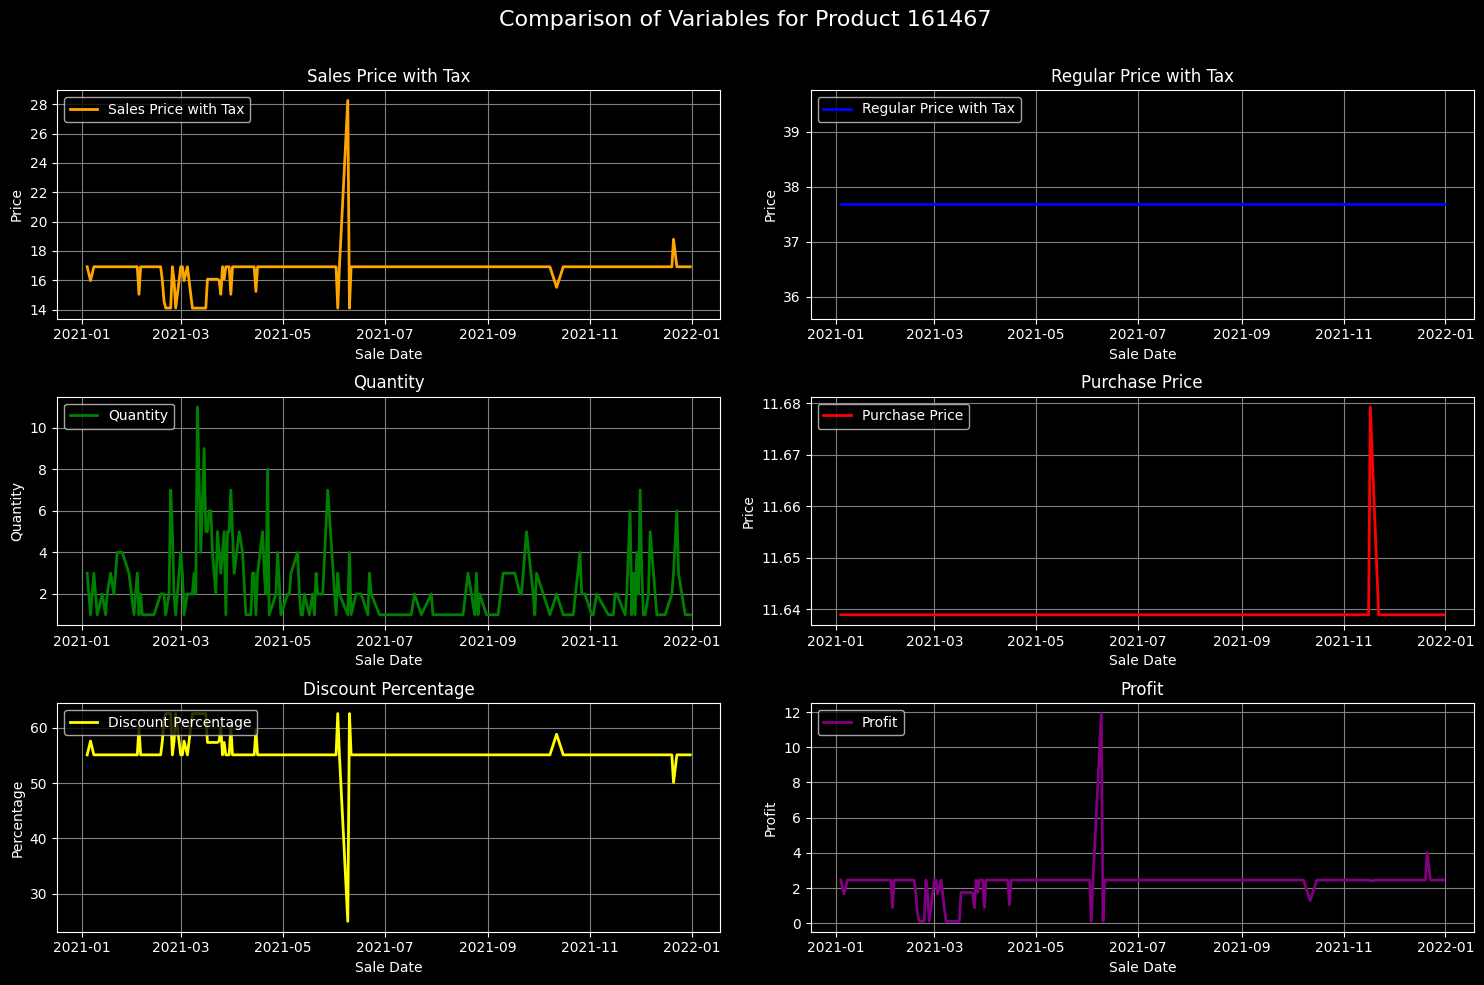

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_product_variables(product_id):
    # Filter the data for the specified product_id
    item_data = sales_data[sales_data["product_id"] == product_id]

    # Convert the 'sale_date' column to datetime if it's not already
    item_data['sale_date'] = pd.to_datetime(item_data['sale_date'])

    # Set up the dark theme
    plt.style.use('dark_background')

    # Set up the subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
    fig.suptitle(f'Comparison of Variables for Product {product_id}', fontsize=16, color='white')

    # Plotting variables
    axes[0, 0].plot(item_data['sale_date'], item_data['sales_price_tax'], label='Sales Price with Tax', color='orange', linewidth=2)
    axes[0, 0].set_title('Sales Price with Tax', color='white')
    axes[0, 0].set_xlabel('Sale Date', color='white')
    axes[0, 0].set_ylabel('Price', color='white')
    axes[0, 0].grid(True, color='gray')

    axes[0, 1].plot(item_data['sale_date'], item_data['regular_price_tax'], label='Regular Price with Tax', color='blue', linewidth=2)
    axes[0, 1].set_title('Regular Price with Tax', color='white')
    axes[0, 1].set_xlabel('Sale Date', color='white')
    axes[0, 1].set_ylabel('Price', color='white')
    axes[0, 1].grid(True, color='gray')

    axes[1, 0].plot(item_data['sale_date'], item_data['quantity'], label='Quantity', color='green', linewidth=2)
    axes[1, 0].set_title('Quantity', color='white')
    axes[1, 0].set_xlabel('Sale Date', color='white')
    axes[1, 0].set_ylabel('Quantity', color='white')
    axes[1, 0].grid(True, color='gray')

    axes[1, 1].plot(item_data['sale_date'], item_data['purchase_price'], label='Purchase Price', color='red', linewidth=2)
    axes[1, 1].set_title('Purchase Price', color='white')
    axes[1, 1].set_xlabel('Sale Date', color='white')
    axes[1, 1].set_ylabel('Price', color='white')
    axes[1, 1].grid(True, color='gray')

    # Calculate discount as a percentage of the regular price
    axes[2, 0].plot(item_data['sale_date'], item_data['discount_percentage'], label='Discount Percentage', color='yellow', linewidth=2)
    axes[2, 0].set_title('Discount Percentage', color='white')
    axes[2, 0].set_xlabel('Sale Date', color='white')
    axes[2, 0].set_ylabel('Percentage', color='white')
    axes[2, 0].grid(True, color='gray')

    # Calculate profit
    axes[2, 1].plot(item_data['sale_date'], item_data['profit'], label='Profit', color='purple', linewidth=2)
    axes[2, 1].set_title('Profit', color='white')
    axes[2, 1].set_xlabel('Sale Date', color='white')
    axes[2, 1].set_ylabel('Profit', color='white')
    axes[2, 1].grid(True, color='gray')

    # Adjust the layout and add legends
    plt.tight_layout()
    for ax in axes.flat:
        ax.legend(loc='upper left', facecolor='black')

    # Display the plot
    plt.subplots_adjust(top=0.9)
    plt.show()

# Assuming you have sales_data loaded with your data
plot_product_variables(161467)


<ipython-input-17-abfc34b6e95e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_data1['sale_date'] = pd.to_datetime(item_data1['sale_date'])
<ipython-input-17-abfc34b6e95e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  item_data2['sale_date'] = pd.to_datetime(item_data2['sale_date'])


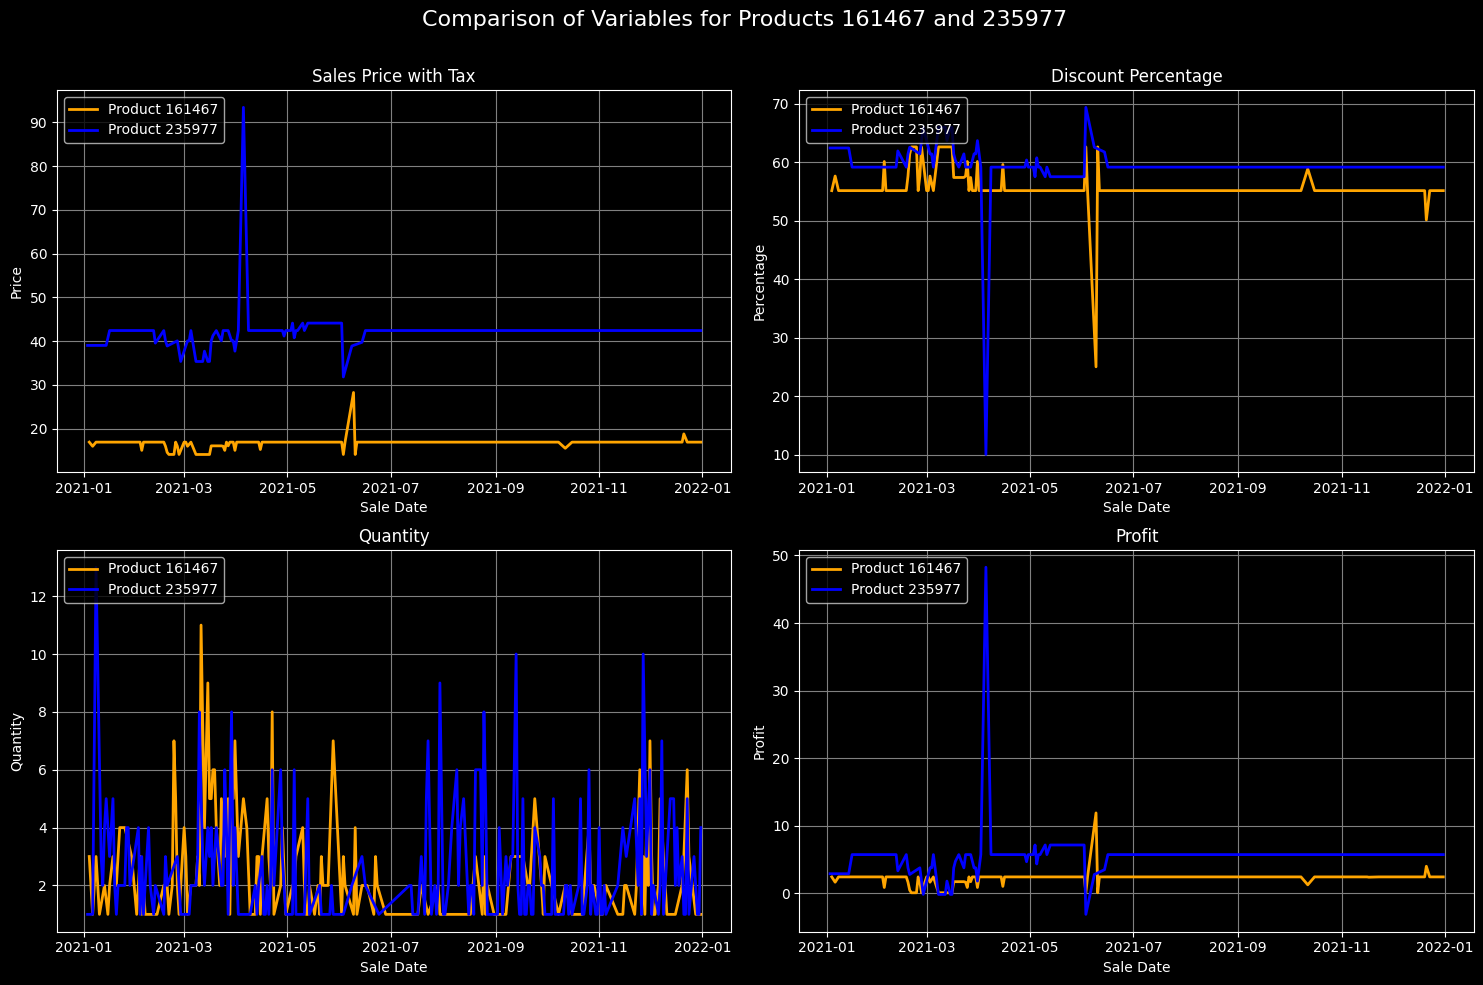

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_product_comparison(product_id1, product_id2):
    # Filter the data for the specified product IDs
    item_data1 = sales_data[sales_data["product_id"] == product_id1]
    item_data2 = sales_data[sales_data["product_id"] == product_id2]

    # Convert the 'sale_date' column to datetime if it's not already
    item_data1['sale_date'] = pd.to_datetime(item_data1['sale_date'])
    item_data2['sale_date'] = pd.to_datetime(item_data2['sale_date'])

    # Set up the dark theme
    plt.style.use('dark_background')

    # Set up the subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    fig.suptitle(f'Comparison of Variables for Products {product_id1} and {product_id2}', fontsize=16, color='white')

    # Plotting variables for the first product in orange and blue colors with thicker lines
    axes[0, 0].plot(item_data1['sale_date'], item_data1['sales_price_tax'], label=f'Product {product_id1}', color='orange', linewidth=2)
    axes[0, 0].plot(item_data2['sale_date'], item_data2['sales_price_tax'], label=f'Product {product_id2}', color='blue', linewidth=2)
    axes[0, 0].set_title('Sales Price with Tax', color='white')
    axes[0, 0].set_xlabel('Sale Date', color='white')
    axes[0, 0].set_ylabel('Price', color='white')
    axes[0, 0].grid(True, color='gray')
    axes[0, 0].legend(loc='upper left')

    axes[1, 0].plot(item_data1['sale_date'], item_data1['quantity'], label=f'Product {product_id1}', color='orange', linewidth=2)
    axes[1, 0].plot(item_data2['sale_date'], item_data2['quantity'], label=f'Product {product_id2}', color='blue', linewidth=2)
    axes[1, 0].set_title('Quantity', color='white')
    axes[1, 0].set_xlabel('Sale Date', color='white')
    axes[1, 0].set_ylabel('Quantity', color='white')
    axes[1, 0].grid(True, color='gray')
    axes[1, 0].legend(loc='upper left')

    # Calculate discount as a percentage of the regular price
    axes[0, 1].plot(item_data1['sale_date'], item_data1['discount_percentage'], label=f'Product {product_id1}', color='orange', linewidth=2)
    axes[0, 1].plot(item_data2['sale_date'], item_data2['discount_percentage'], label=f'Product {product_id2}', color='blue', linewidth=2)
    axes[0, 1].set_title('Discount Percentage', color='white')
    axes[0, 1].set_xlabel('Sale Date', color='white')
    axes[0, 1].set_ylabel('Percentage', color='white')
    axes[0, 1].grid(True, color='gray')
    axes[0, 1].legend(loc='upper left')

    # Calculate profit
    axes[1, 1].plot(item_data1['sale_date'], item_data1['profit'], label=f'Product {product_id1}', color='orange', linewidth=2)
    axes[1, 1].plot(item_data2['sale_date'], item_data2['profit'], label=f'Product {product_id2}', color='blue', linewidth=2)
    axes[1, 1].set_title('Profit', color='white')
    axes[1, 1].set_xlabel('Sale Date', color='white')
    axes[1, 1].set_ylabel('Profit', color='white')
    axes[1, 1].grid(True, color='gray')
    axes[1, 1].legend(loc='upper left')

    # Adjust the layout
    plt.tight_layout()

    # Display the plot
    plt.subplots_adjust(top=0.9)
    plt.show()

# Assuming you have sales_data loaded with your data
plot_product_comparison(161467, 235977)


<ipython-input-72-132c0850f132>:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = sales_data_no_id.corr()


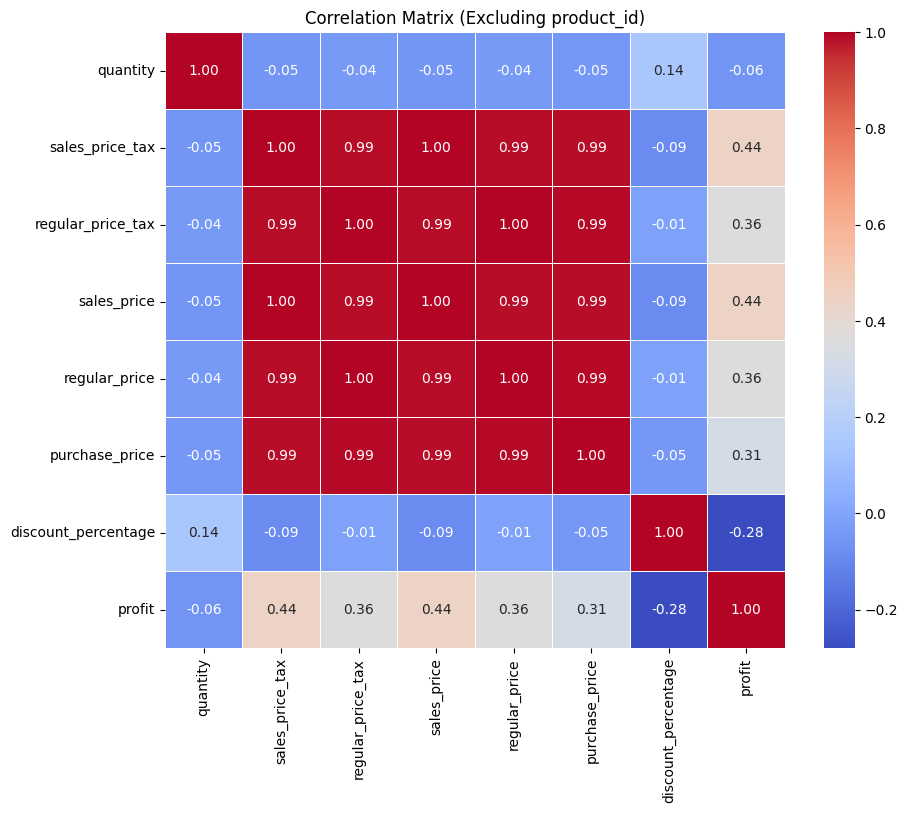

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your data is loaded into a DataFrame called 'sales_data'

# Remove the 'product_id' column
sales_data_no_id = sales_data.drop(columns=['product_id'])

# Calculate the correlation matrix
correlation_matrix = sales_data_no_id.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix (Excluding product_id)')
plt.show()

### Prices Competitor

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns2

# Display the first few rows
print(prices_competitor.head(20))

     comp_date  seller_id  product_id     price
0   2021-01-01        529      165096  237.9150
1   2021-01-01        576      165096  237.9150
2   2021-01-01        676      165096  237.9150
3   2021-01-01       1681      165096  233.6650
4   2021-01-01       2304      165096  237.9150
5   2021-01-01      32400      165096  246.4150
6   2021-01-01     165649      165096  243.0150
7   2021-01-01        576      226578   89.2415
8   2021-01-01        676      226578   89.2415
9   2021-01-01       2304      226578   99.1610
10  2021-01-01        529      166233   21.2415
11  2021-01-01        576      166233   15.2150
12  2021-01-01        676      166233   15.2150
13  2021-01-01       1681      166233   21.1650
14  2021-01-01       2304      166233   15.2150
15  2021-01-01      32400      166233   16.9915
16  2021-01-01        576      166105    7.5650
17  2021-01-01        576      205210   80.6650
18  2021-01-01        676      205210   80.6650
19  2021-01-01       1681      205210   

In [ ]:
prices_competitor['seller_id'].value_counts()

576       1791169
676       1338029
2304      1169189
32400      925195
1681       881363
165649     686502
529        670980
35344      594913
240100     415696
Name: seller_id, dtype: int64

In [ ]:
prices_competitor['product_id'].value_counts()

208557    3310
209931    3302
209317    3293
202759    3291
202203    3279
          ... 
226941       8
266863       6
247093       5
247198       5
213577       3
Name: product_id, Length: 6461, dtype: int64

In [ ]:
seller_id = 576

seller_products = prices_competitor[prices_competitor['seller_id'] == seller_id]

# Get unique product IDs associated with the seller
unique_product_ids = seller_products['product_id'].unique()

# Get the number of unique products for the seller
num_products = len(unique_product_ids)

# Print the list of unique product IDs and the number of products for the seller
print("Seller", seller_id, "has", num_products, "unique product(s) with IDs:", unique_product_ids)


Seller 576 has 6455 unique product(s) with IDs: [165096 226578 166233 ... 266863 275677 227299]


In [ ]:
product_id = 166233

product_sellers = prices_competitor[prices_competitor['product_id'] == product_id]

# Get unique seller IDs associated with the product
unique_seller_ids = product_sellers['seller_id'].unique()

# Get the number of unique sellers for the product
num_sellers = len(unique_seller_ids)

# Print the product ID and the number of sellers for the product
print("Product", product_id, "has", num_sellers, "unique seller(s) with IDs:", unique_seller_ids)

Product 166233 has 8 unique seller(s) with IDs: [   529    576    676   1681   2304  32400 165649 240100]


<ipython-input-8-1cd013369b26>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['comp_date'] = pd.to_datetime(filtered_data['comp_date'])


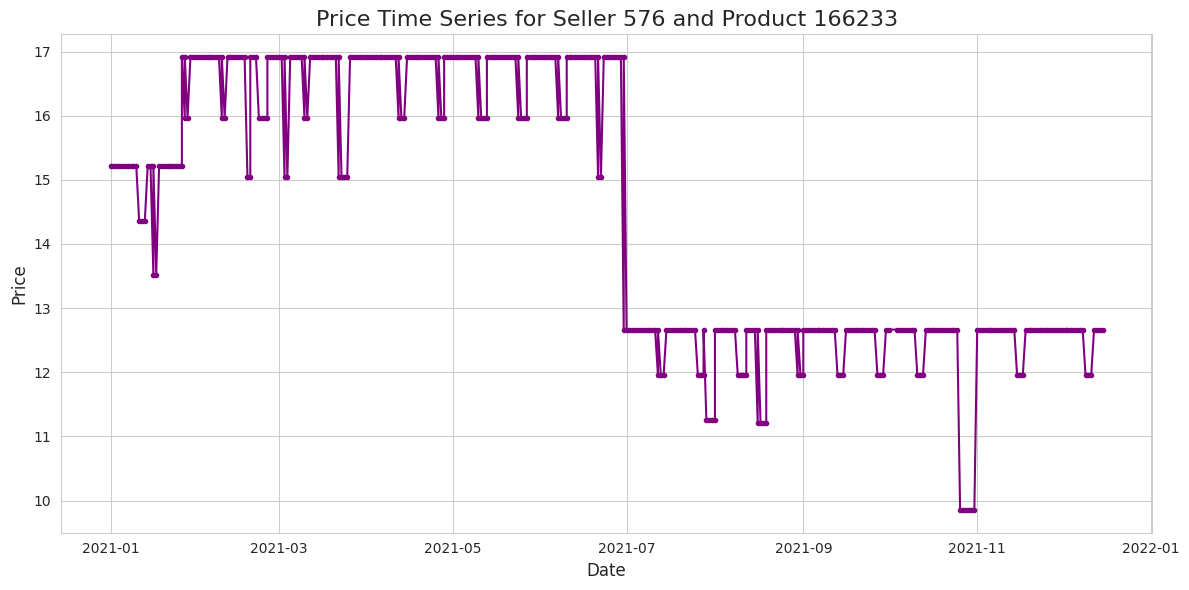

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_price_time_series(seller_id, product_id):
    # Step 1: Filter data for the specified seller and product
    filtered_data = prices_competitor[(prices_competitor['seller_id'] == seller_id) & (prices_competitor['product_id'] == product_id)]

    # Step 2: Convert 'comp_date' column to a datetime type
    filtered_data['comp_date'] = pd.to_datetime(filtered_data['comp_date'])

    # Set style using seaborn
    sns.set_style("whitegrid")

    # Create a time series plot with custom style
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['comp_date'], filtered_data['price'], marker='.', linestyle='-', color='purple', label='Price')

    # Adding labels and title
    plt.title(f'Price Time Series for Seller {seller_id} and Product {product_id}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price', fontsize=12)

    # Adding grid lines
    plt.grid(True)

    # Show plot
    plt.tight_layout()
    plt.show()

# Example usage:
plot_price_time_series(576, 166233)

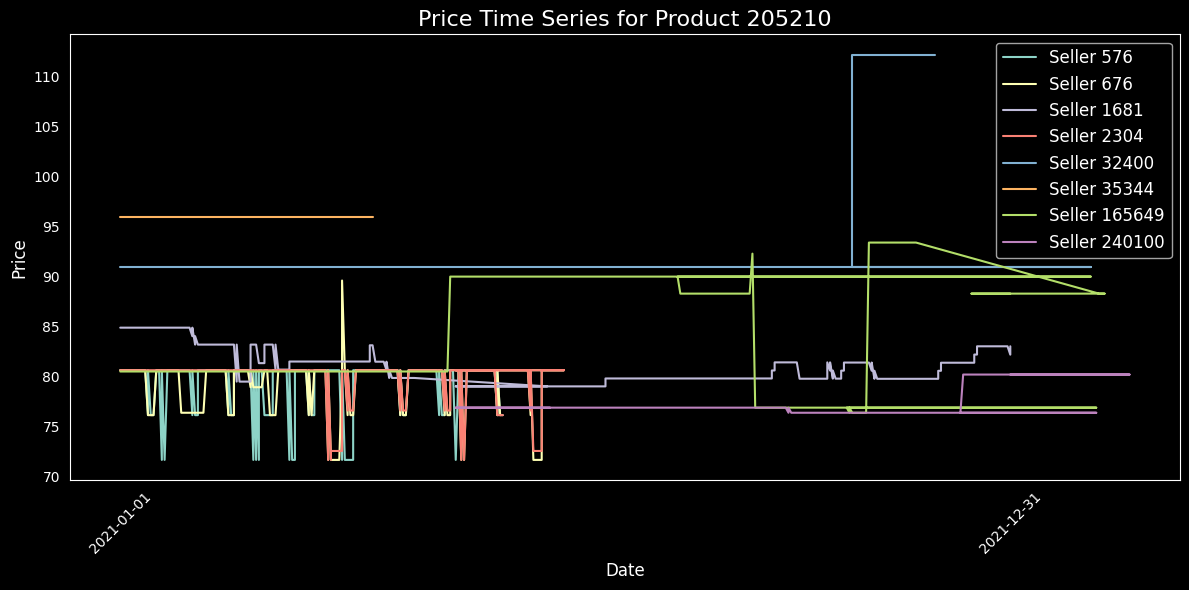

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_product_time_series(product_id):
    # Filter the DataFrame for the specified product
    product_data = prices_competitor[prices_competitor['product_id'] == product_id]

    # Get unique seller IDs for the product
    unique_seller_ids = product_data['seller_id'].unique()

    # Use Matplotlib's dark theme
    plt.style.use('dark_background')

    # Create a time series plot for each seller
    plt.figure(figsize=(12, 6))
    for seller_id in unique_seller_ids:
        seller_data = product_data[product_data['seller_id'] == seller_id]
        plt.plot(seller_data['comp_date'], seller_data['price'], label=f'Seller {seller_id}')

        # Calculate and print mean price and standard deviation for the seller
        mean_price = seller_data['price'].mean()
        std_dev = seller_data['price'].std()
        #print(f'\n Seller {seller_id} - Mean Price: {mean_price:.2f}, Std Dev: {std_dev:.2f}')

    # Adding labels and title
    plt.title(f'Price Time Series for Product {product_id}', fontsize=16, color='white')
    plt.xlabel('Date', fontsize=12, color='white')
    plt.ylabel('Price', fontsize=12, color='white')

    # Adding legend
    plt.legend(loc='best', fontsize=12)

    # Turn off gridlines
    plt.grid(False)

    # Display only the first and last date on the x-axis
    x_ticks = [product_data['comp_date'].min(), product_data['comp_date'].max()]
    plt.xticks(x_ticks, rotation=45)

    # Show plot
    plt.tight_layout()
    plt.show()

# Assuming you have prices_competitor DataFrame loaded with your data
plot_product_time_series(205210)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random

def plot_product_time_series(product_id):
    # Filter the DataFrame for the specified product
    product_data = prices_competitor[prices_competitor['product_id'] == product_id]

    # Get unique seller IDs for the product
    unique_seller_ids = product_data['seller_id'].unique()

    # Use Matplotlib's dark theme
    plt.style.use('dark_background')

    #tickness of the lines
    plt.rcParams['lines.linewidth'] = 2

    # Create a time series plot for each seller
    plt.figure(figsize=(12, 6))
    for seller_id in unique_seller_ids:
        seller_data = product_data[product_data['seller_id'] == seller_id]
        plt.plot(seller_data['comp_date'], seller_data['price'], label=f'Seller {seller_id}')

        # Calculate and print mean price and standard deviation for the seller
        mean_price = seller_data['price'].mean()
        std_dev = seller_data['price'].std()
        #print(f'\nSeller {seller_id} - Mean Price: {mean_price:.2f}, Std Dev: {std_dev:.2f}')

    # Adding labels and title
    plt.title(f'Price Time Series for Product {product_id}', fontsize=16, color='white')
    plt.xlabel('Date', fontsize=12, color='white')
    plt.ylabel('Price', fontsize=12, color='white')

    # Adding legend
    plt.legend(loc='best', fontsize=12)

    # Turn off gridlines
    plt.grid(False)

    # Display only the first and last date on the x-axis
    x_ticks = [product_data['comp_date'].min(), product_data['comp_date'].max()]
    plt.xticks(x_ticks, rotation=45)

    # Show plot
    plt.tight_layout()
    plt.show()

random_product_ids = random.sample(prices_competitor['product_id'].unique().tolist(), 20)

# Plot each product time series one at a time
for product_id in random_product_ids:
    plot_product_time_series(product_id)


### product_catalog

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display the first few rows
print(product_catalog.head())

   product_id  coded_cat1  coded_cat2  coded_cat3  coded_brand  coded_name
0      164766        2664        2256        1098          550        2308
1      179061        2664        2256        1098          550        2622
2      196518        2664        2256        2860          550        4273
3      196546        2664        2256        2860          550        4261
4      196959        2664        2256        2860          319        4117


### clicks_regular

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display the first few rows
print(clicks_regular.head())

# Check for missing values
print(clicks_regular.isnull().sum())

In [ ]:
nan_values = clicks_regular[clicks_regular['price'].isnull()]

In [ ]:
# rebuild the price_max and price_min columns from prices_competitor in order to impute the missing prices

In [ ]:
# impute the price with the mean between the rebuilt price_max and price_min columns

In [ ]:
clicks_regular['seller'].value_counts()

576       588560
32400     381710
676       344792
1681      309989
165649    196081
2304      170712
35344     156293
529        80321
240100     24473
Name: seller, dtype: int64

### clicks_bidding

merge clicks bidding and regular

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Display the first few rows
print(clicks_bidding.head())

                  date  seller  position  price_max  price_min    price  \
0  2021-04-02 11:48:02    2304         1   220.9150   186.9150  220.915   
1  2021-04-02 11:48:04   32400         1   441.9150   365.4065  386.665   
2  2021-04-02 11:48:15     576         1   458.9150   414.7065  329.715   
3  2021-04-02 11:48:16    2304         1    90.9415    71.8250   76.415   
4  2021-04-02 11:48:59     576         1   571.1915   571.1915  475.915   

      type  product_id  
0  Bidding      210714  
1  Bidding      185409  
2  Bidding      235927  
3  Bidding      169654  
4  Bidding      227062  


In [ ]:
clicks_bidding['seller'].value_counts()

576       304332
676       179788
165649     78312
1681       43871
2304       43860
240100     20217
32400      15556
35344      10054
529         1009
Name: seller, dtype: int64

## Data Cleaning

In [ ]:
!pip install pyspark -q

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# Create SparkSession
spark = SparkSession.builder \
    .master("local") \
    .appName("NYC Safety")\
    .config("spark.driver.memory", "15g")\
    .getOrCreate()

#set number of partitions
spark.conf.set("spark.sql.shuffle.partitions", 2)

In [ ]:
sales_data = spark.read.csv('/content/drive/MyDrive/University/BSDA/Alkemy_project_data/sales_data.csv', header=True)
product_catalog = spark.read.csv('/content/drive/MyDrive/University/BSDA/Alkemy_project_data/coded_product_catalog.csv', header=True)
stock_data = spark.read.csv('/content/drive/MyDrive/University/BSDA/Alkemy_project_data/stock.csv', header=True)
sellers_list = spark.read.csv('/content/drive/MyDrive/University/BSDA/Alkemy_project_data/sellers_list.csv', header=True)
clicks_regular = spark.read.csv('/content/drive/MyDrive/University/BSDA/Alkemy_project_data/clicks_regular.csv', header=True)
clicks_bidding = spark.read.csv('/content/drive/MyDrive/University/BSDA/Alkemy_project_data/clicks_bidding.csv', header=True)
prices_competitor = spark.read.csv('/content/drive/MyDrive/University/BSDA/Alkemy_project_data/prices_competitor.csv', header=True)

In [ ]:
# Function to check missing values in a DataFrame
def check_missing_values(df):
    missing_values = {}
    for column in df.columns:
        missing_count = df.filter(df[column].isNull()).count()
        missing_values[column] = missing_count
    return missing_values

In [ ]:
# Check missing values in each DataFrame
missing_values_sales_data = check_missing_values(sales_data)
missing_values_product_catalog = check_missing_values(product_catalog)
missing_values_stock = check_missing_values(stock_data)
missing_values_sellers_list = check_missing_values(sellers_list)
missing_values_clicks_regular = check_missing_values(clicks_regular)
missing_values_clicks_bidding = check_missing_values(clicks_bidding)
missing_values_prices_competitor = check_missing_values(prices_competitor)

# Display missing values counts for each DataFrame
print("Missing values in sales_data_df:")
print(missing_values_sales_data)

print("Missing values in product_catalog_df:")
print(missing_values_product_catalog)

print("Missing values in stock_df:")
print(missing_values_stock)

print("Missing values in sellers_list_df:")
print(missing_values_sellers_list)

print("Missing values in clicks_regular_df:")
print(missing_values_clicks_regular)

print("Missing values in clicks_bidding_df:")
print(missing_values_clicks_bidding)

print("Missing values in prices_competitor_df:")
print(missing_values_prices_competitor)

Missing values in sales_data_df:
{'sale_date': 0, 'product_id': 0, 'quantity': 0, 'sales_price_tax': 0, 'regular_price_tax': 0, 'sales_price': 0, 'regular_price': 0, 'purchase_price': 0}
Missing values in product_catalog_df:
{'product_id': 0, 'coded_cat1': 0, 'coded_cat2': 0, 'coded_cat3': 0, 'coded_brand': 0, 'coded_name': 0}
Missing values in stock_df:
{'stock_date': 0, 'product_id': 0, 'total_stock': 0}
Missing values in sellers_list_df:
{'seller_id': 0, 'seller_name': 0}
Missing values in clicks_regular_df:
{'date': 0, 'seller': 0, 'position': 1093664, 'price_max': 0, 'price_min': 0, 'price': 1093244, 'type': 0, 'product_id': 0}
Missing values in clicks_bidding_df:
{'date': 0, 'seller': 0, 'position': 0, 'price_max': 0, 'price_min': 0, 'price': 0, 'type': 0, 'product_id': 0}
Missing values in prices_competitor_df:
{'comp_date': 0, 'seller_id': 0, 'product_id': 0, 'price': 0}


In [ ]:
# Impute missing values in the "position" column with 0
clicks_regular = clicks_regular.fillna(0, subset=["position"])

# Show the DataFrame to verify the imputation
clicks_regular.show()

+-------------------+------+--------+------------------+------------------+-----+-------+----------+
|               date|seller|position|         price_max|         price_min|price|   type|product_id|
+-------------------+------+--------+------------------+------------------+-----+-------+----------+
|2020-01-01 00:28:01|  2304|    NULL|            44.965|            44.965| NULL|Regular|    223312|
|2020-01-01 00:29:40|  2304|    NULL|100.18950000000001|            84.915| NULL|Regular|    156807|
|2020-01-01 00:30:39|   529|    NULL|          137.8445|          137.8445| NULL|Regular|    162424|
|2020-01-01 00:42:23|  2304|    NULL| 62.89150000000001|            54.383| NULL|Regular|    217077|
|2020-01-01 00:42:51|165649|    NULL|           28.4155|19.541500000000003| NULL|Regular|    217164|
|2020-01-01 00:42:57|   576|    NULL|          110.4915|           80.6735| NULL|Regular|    198951|
|2020-01-01 00:44:21|   576|    NULL| 92.56500000000001|            78.965| NULL|Regular|  

In [ ]:
prices_competitor.show()

+----------+---------+----------+------------------+
| comp_date|seller_id|product_id|             price|
+----------+---------+----------+------------------+
|2021-01-01|      529|    165096|237.91500000000002|
|2021-01-01|      576|    165096|237.91500000000002|
|2021-01-01|      676|    165096|237.91500000000002|
|2021-01-01|     1681|    165096|233.66500000000002|
|2021-01-01|     2304|    165096|237.91500000000002|
|2021-01-01|    32400|    165096|246.41500000000002|
|2021-01-01|   165649|    165096|243.01500000000001|
|2021-01-01|      576|    226578|           89.2415|
|2021-01-01|      676|    226578|           89.2415|
|2021-01-01|     2304|    226578|            99.161|
|2021-01-01|      529|    166233|21.241500000000002|
|2021-01-01|      576|    166233|15.215000000000002|
|2021-01-01|      676|    166233|15.215000000000002|
|2021-01-01|     1681|    166233|21.165000000000003|
|2021-01-01|     2304|    166233|15.215000000000002|
|2021-01-01|    32400|    166233|16.9915000000

# Task 1

In [ ]:
#Merge, Filter, Group, and Extract Unique Sellers from Competitor Prices DataFrame

prices_competitor = prices_competitor.join(sellers_list, on='seller_id', how='left').drop('seller_id')

df = prices_competitor.filter(prices_competitor['product_id'] == 208557)

df = df.groupBy('seller_name', 'comp_date', 'product_id').agg(mean('price').alias('price'))

unique_sellers = df.select('seller_name').distinct()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from matplotlib.dates import DayLocator
from collections import defaultdict
from itertools import combinations

class SellerAnalysis:
    """

    A class for analyzing correlations and relationships among sellers based on their pricing data.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing pricing data.
    - window_size (int): The size of the time window for correlation analysis (default is 7 days).
    - max_lag (int): The maximum lag to consider for cross-correlation analysis (default is 3 days).
    - start_date (str): The start date for analysis in 'YYYY-MM-DD' format.
    - end_date (str): The end date for analysis in 'YYYY-MM-DD' format.

    Attributes:
    - df (pd.DataFrame): The input DataFrame.
    - seller_column (pd.Series): The column containing seller names.
    - unique_sellers (numpy.ndarray): An array of unique seller names.
    - window_size (int): The size of the time window for correlation analysis.
    - max_lag (int): The maximum lag to consider for cross-correlation analysis.
    - start_date (str): The start date for analysis.
    - end_date (str): The end date for analysis.

    Methods:
    - crosscorr(datax, datay, lag): Calculates the cross-correlation between two time series.
    - correlation(sellers, start_date, end_date, max_lag): Computes the correlation between two sellers within a specified time frame.
    - table_leader_followers(): Generates a DataFrame showing leader-follower relationships among sellers over time.
    - plot_correlations(): Plots the original price comparison and cross-correlation between two sellers.


    """
    def __init__(self, df, window_size=7, max_lag=3, start_date=None, end_date=None):
        self.df = df
        self.seller_column = df['seller_name']
        self.unique_sellers = self.seller_column.unique()
        self.window_size = window_size
        self.max_lag = max_lag
        self.start_date = start_date
        self.end_date = end_date

    def crosscorr(self, datax, datay, lag=0):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            return datax.corr(datay.shift(lag))

    def correlation(self, sellers, start_date, end_date, max_lag):
        '''

        1. Data Filtering and Preparation:
          - Filters the original DataFrame (`self.df`) to include only data for the specified sellers (`sellers`) within the given time frame (`start_date` to `end_date`).
          - Converts the 'comp_date' column to datetime format, sorts the data based on 'comp_date', and sets 'comp_date' as the index.

        2. Extracting Price Data:
          - Extracts the price time series for each of the two sellers (`sellers[0]` and `sellers[1]`) from the filtered data.

        3. Cross-Correlation Computation:
          - Calculates the cross-correlation between the price time series of the two sellers over a range of lags using the `crosscorr` method.

        4. Handling NaN Values:
          - Filters out NaN values from the calculated cross-correlations.

        5. Determining Maximum Positive Correlation:
          - Identifies the maximum positive correlation and its corresponding lag among the non-NaN cross-correlations.

        6. Leader-Follower Determination:
          - Determines the leader and follower based on the sign of the lag.

        7. Output:
          - Returns a tuple containing information about the leader (`seller_1_name`), follower (`seller_2_name`), and the maximum positive correlation.

        '''

        filtered_data = self.df[self.df['seller_name'].isin(sellers)]
        filtered_data = filtered_data[(filtered_data['comp_date'] >= start_date) & (filtered_data['comp_date'] <= end_date)]
        filtered_data['comp_date'] = pd.to_datetime(filtered_data['comp_date'])
        filtered_data = filtered_data.sort_values(by='comp_date')
        filtered_data = filtered_data.set_index('comp_date')
        seller_1_price = filtered_data[filtered_data['seller_name'] == sellers[0]]['price']
        seller_2_price = filtered_data[filtered_data['seller_name'] == sellers[1]]['price']

        cross_correlations_price = [self.crosscorr(seller_1_price, seller_2_price, lag) for lag in range(-max_lag, max_lag + 1)]

        non_nan_correlations = [corr for corr in cross_correlations_price if not np.isnan(corr)]

        if non_nan_correlations:
            max_positive_corr = max(non_nan_correlations)
            max_positive_corr_lag = cross_correlations_price.index(max_positive_corr) - max_lag
        else:
            max_positive_corr = None
            max_positive_corr_lag = None

        seller_1_name = sellers[0]
        seller_2_name = sellers[1]

        if max_positive_corr_lag is not None:
            if max_positive_corr_lag > 0:
                return seller_1_name, seller_2_name, max_positive_corr
            elif max_positive_corr_lag < 0:
                return seller_2_name, seller_1_name, max_positive_corr
        return None

    def table_leader_followers(self):

        '''

        1. Initialization:
          - Initializes a dictionary (`followers_dict`) to store leader-follower relationships within time windows.
          - Creates an empty list (`time_windows`) to store unique time windows.
          - Generates combinations of unique seller pairs.

        2. Iterating Through Seller Pairs and Timeframes:
          - Iterates over each seller pair and specified time windows.
          - For each time window, calculates the correlation between the seller pair using the `correlation` method.

        3. Building the `followers_dict`:
          - If a correlation result exists (i.e., there is a leader-follower relationship), updates `followers_dict` with the leader and follower for the specific time window.

        4. Constructing the Data for DataFrame:
          - Creates a list (`data`) to store rows of data for constructing the DataFrame.
          - Creates a list of unique sellers involved in the combinations.

        5. Populating Data Rows:
          - Iterates over each seller and time window to populate the rows of the DataFrame.
          - Retrieves the followers for each seller within a time window and constructs a row.

        6. DataFrame Construction:
          - Creates a DataFrame (`df_leader_follower`) from the constructed data with columns representing leaders and followers in various time windows.

        7. Output:
          - Returns the generated DataFrame representing leader-follower relationships over time windows.

        '''

        if self.start_date is None or self.end_date is None:
            raise ValueError("Please specify the start_date and end_date.")
        followers_dict = defaultdict(lambda: defaultdict(list))
        time_windows = []
        seller_combinations = list(combinations(self.unique_sellers, 2))

        for seller_pair in seller_combinations:
            seller_1, seller_2 = seller_pair
            current_start_date = self.start_date
            while pd.to_datetime(current_start_date) < pd.to_datetime(self.end_date):
                current_end_date = (pd.to_datetime(current_start_date) + pd.DateOffset(days=self.window_size)).strftime('%Y-%m-%d')
                time_window = f"{current_start_date} to {current_end_date}"

                if time_window not in time_windows:
                    time_windows.append(time_window)

                result = self.correlation([seller_1, seller_2], current_start_date, current_end_date, self.max_lag)
                if result:
                    follower, leader, _ = result

                    if follower not in followers_dict[leader][time_window]:
                        followers_dict[leader][time_window].append(follower)

                current_start_date = (pd.to_datetime(current_start_date) + pd.DateOffset(days=self.window_size)).strftime('%Y-%m-%d')

        data = []
        sellers = list(set([seller for pair in seller_combinations for seller in pair]))
        for seller in sellers:
            row = [seller]
            for time_window in time_windows:
                followers = ', '.join(followers_dict[seller][time_window])
                row.append(followers if followers else np.nan)
            data.append(row)

        columns = ['Leader'] + time_windows
        df_leader_follower = pd.DataFrame(data, columns=columns)
        return df_leader_follower

    def plot_correlations(self):
        '''
        1. Generates all unique combinations of seller pairs.

        2. Iterating Through Seller Pairs and Timeframes:

        3. Filters and preprocesses the data for the specific seller pair and timeframe.

        4. Computes cross-correlation between the sellers' price time series.

        5. Identifies leaders and followers based on the correlation lag.

        6. Prints information about the correlation, lag, and leader-follower relationship.

        7. Generates visualizations (if correlation is significant) showing original price comparisons and cross-correlation plots.
        '''
        if self.start_date is None or self.end_date is None:
            raise ValueError("Please specify the start_date and end_date.")
        seller_combinations = list(combinations(self.unique_sellers, 2))

        for seller_pair in seller_combinations:
            print('-------------------------')
            seller_1, seller_2 = seller_pair
            print(f"\nSeller Pair: {seller_1} and {seller_2}\n")

            current_start_date = self.start_date
            while pd.to_datetime(current_start_date) < pd.to_datetime(self.end_date):
                current_end_date = (pd.to_datetime(current_start_date) + pd.DateOffset(days=self.window_size)).strftime('%Y-%m-%d')
                print(f"Timeframe: {current_start_date} to {current_end_date}")

                filtered_data = self.df[self.df['seller_name'].isin([seller_1, seller_2])]
                filtered_data = filtered_data[(filtered_data['comp_date'] >= current_start_date) & (filtered_data['comp_date'] <= current_end_date)]
                filtered_data['comp_date'] = pd.to_datetime(filtered_data['comp_date'])
                filtered_data = filtered_data.sort_values(by='comp_date')
                filtered_data = filtered_data.set_index('comp_date')

                seller_1_price = filtered_data[filtered_data['seller_name'] == seller_1]['price']
                seller_2_price = filtered_data[filtered_data['seller_name'] == seller_2]['price']
                seller_1_diff = seller_1_price.diff()
                seller_2_diff = seller_2_price.diff()

                cross_correlations_price = [self.crosscorr(seller_1_price, seller_2_price, lag) for lag in range(-self.max_lag, self.max_lag + 1)]

                non_nan_correlations = [corr for corr in cross_correlations_price if not np.isnan(corr)]

                if non_nan_correlations:
                    max_positive_corr = max(non_nan_correlations)
                    max_positive_corr_lag = cross_correlations_price.index(max_positive_corr) - self.max_lag
                else:
                    max_positive_corr = None
                    max_positive_corr_lag = None

                seller_1_name = seller_1
                seller_2_name = seller_2

                if max_positive_corr_lag is not None:
                    if max_positive_corr_lag > 0:
                        following_message = f"Leader: {seller_2_name}, Follower: {seller_1_name}"
                    elif max_positive_corr_lag < 0:
                        following_message = f"Leader: {seller_1_name}, Follower: {seller_2_name}"
                    else:
                        following_message = "Automated System"
                else:
                    following_message = "No correlation in this time frame."

                if max_positive_corr is not None:
                    if max_positive_corr >= 0.2:

                        print("Correlation Analysis:")
                        print(f"Correlation: {max_positive_corr:.2f}")
                        print(f"Lag: {abs(max_positive_corr_lag)} days")
                        print(f"Following: {following_message}\n")

                        plt.figure(figsize=(12, 8))

                        ax1 = plt.subplot(2, 2, 1)
                        plt.plot(seller_1_price, label=seller_1_name, color='blue')
                        plt.plot(seller_2_price, label=seller_2_name, color='red')
                        plt.xlabel('Date')
                        plt.ylabel('Price')
                        plt.title(f"Graph for Week: {current_start_date} - {current_end_date} \n {following_message}")
                        ax1.xaxis.set_major_locator(DayLocator(interval=1))
                        plt.xticks(rotation=90)
                        plt.legend()
                        plt.grid(True)

                        plt.subplot(2, 2, 2)
                        plt.plot(range(-self.max_lag, self.max_lag + 1), cross_correlations_price, marker='o', linestyle='-', color='green')
                        plt.title(f"Cross-correlation between {seller_1_name} and {seller_2_name} (based on original prices)")
                        plt.xlabel("Lag (Days)")
                        plt.ylabel("Cross-correlation")
                        plt.grid(True)

                        plt.tight_layout()
                        plt.show()
                    else:
                        print("Correlation Analysis:")
                        print("The correlation is too low or negative\n")
                else:
                    print("Correlation Analysis:")
                    print(f"{following_message}\n")

                current_start_date = (pd.to_datetime(current_start_date) + pd.DateOffset(days=self.window_size)).strftime('%Y-%m-%d')


In [ ]:
# Initialize the class for the specific Periods (November for Black Friday).
# To change the period, change the start_date and end_date

#df = df.toPandas()

seller_analysis = SellerAnalysis(df, start_date='2021-09-01', end_date='2021-09-30', window_size=7, max_lag=3)

-------------------------

Seller Pair: M and P

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
Correlation: 0.25
Lag: 3 days
Following: Leader: P, Follower: M



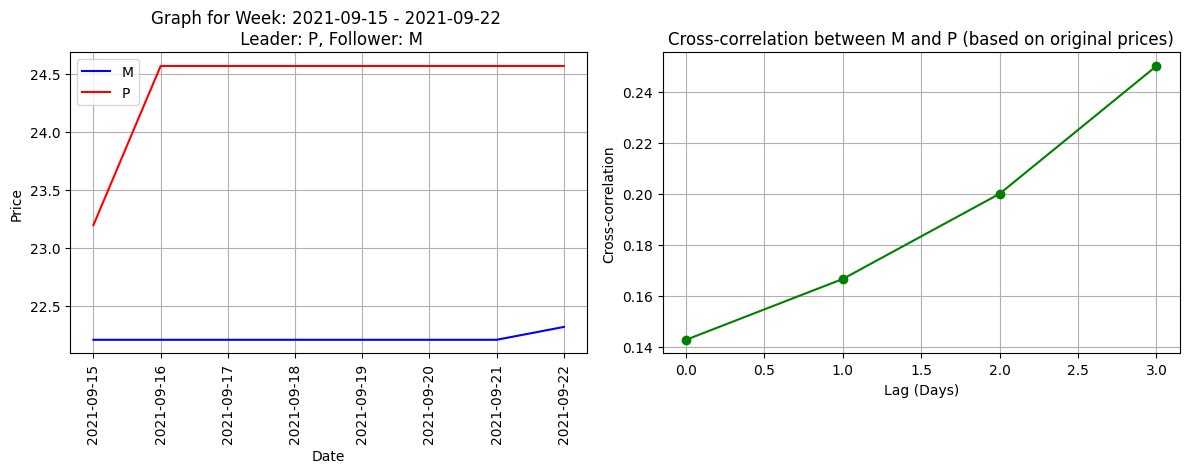

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
Correlation: 0.51
Lag: 0 days
Following: Automated System



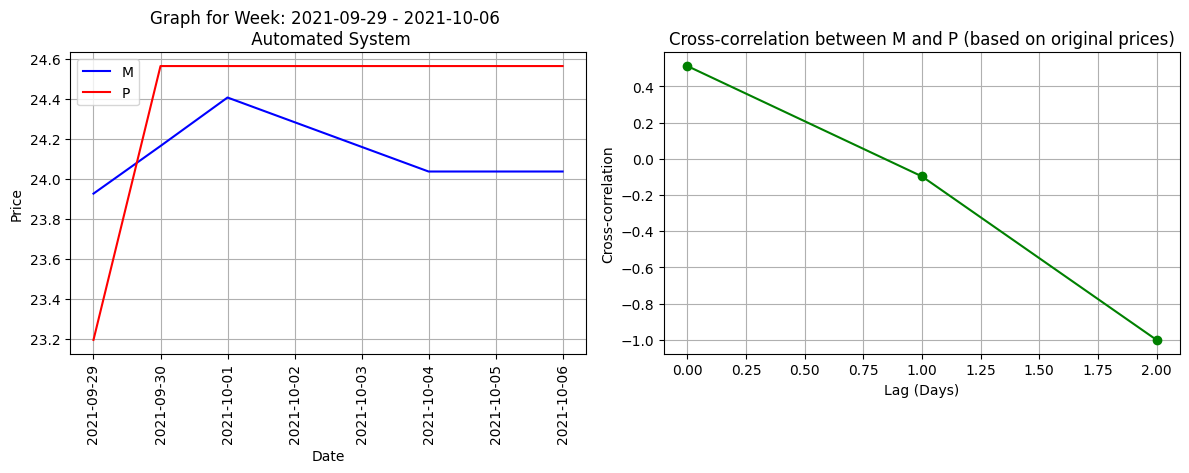

-------------------------

Seller Pair: M and Z

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: M and C

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06


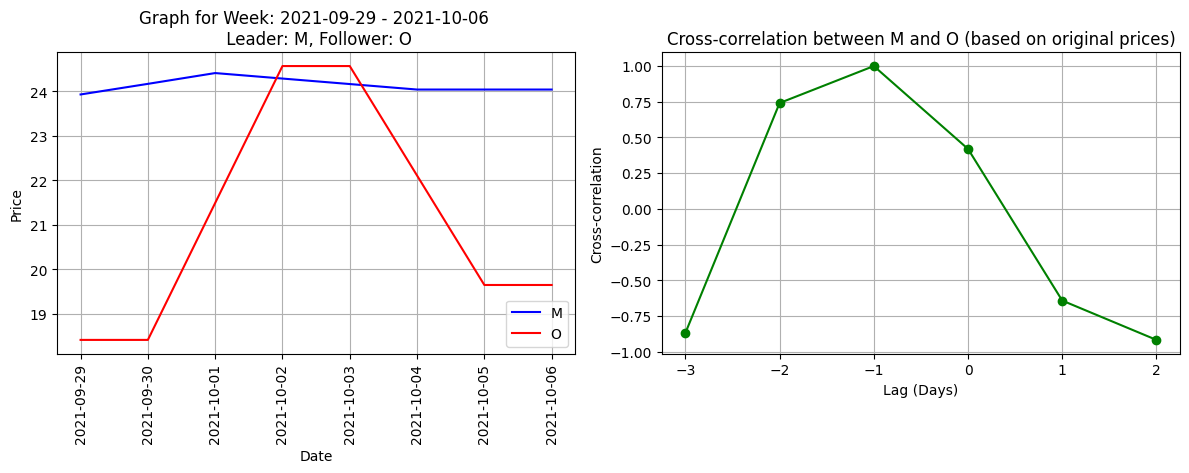

-------------------------

Seller Pair: M and I

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
Correlation: 0.57
Lag: 1 days
Following: Leader: M, Follower: I



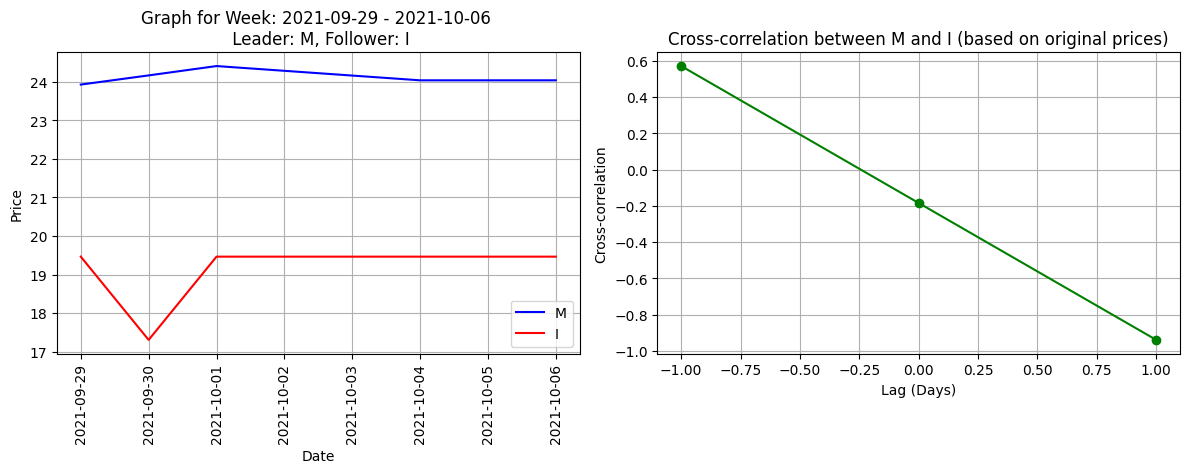

-------------------------

Seller Pair: M and T

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: M and E

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-29 to 2021-10-06
Corr

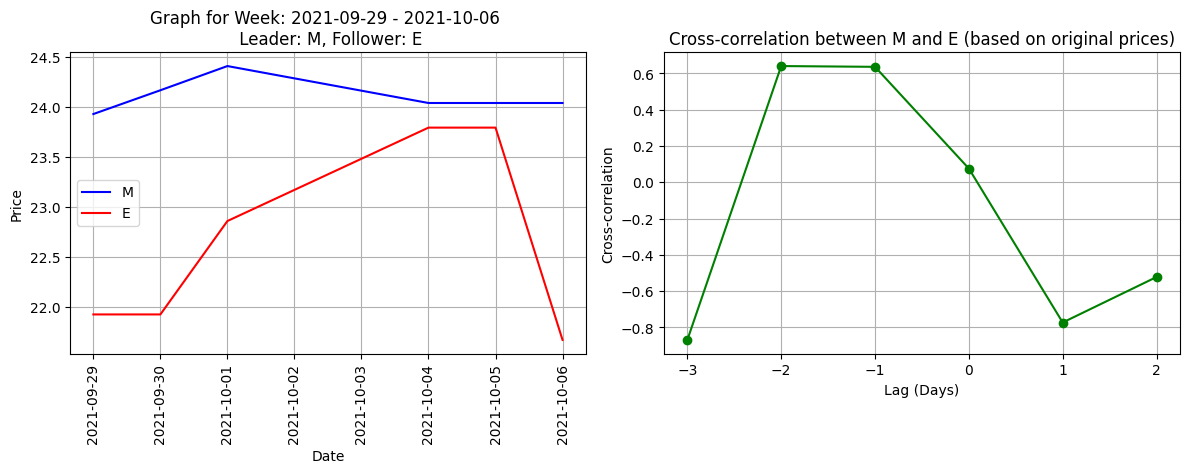

-------------------------

Seller Pair: P and Z

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
Correlation: 0.54
Lag: 2 days
Following: Leader: P, Follower: Z



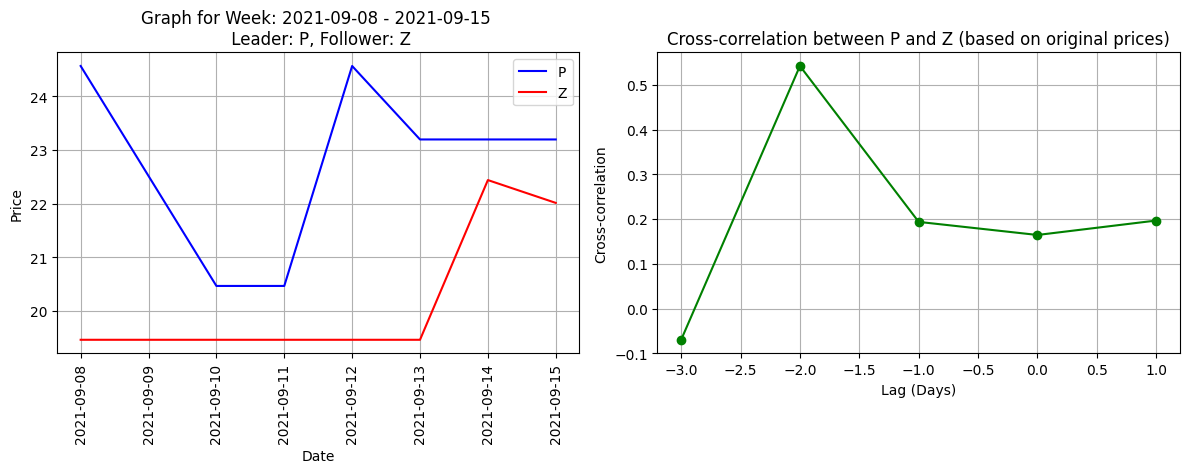

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
Correlation: 0.61
Lag: 3 days
Following: Leader: Z, Follower: P



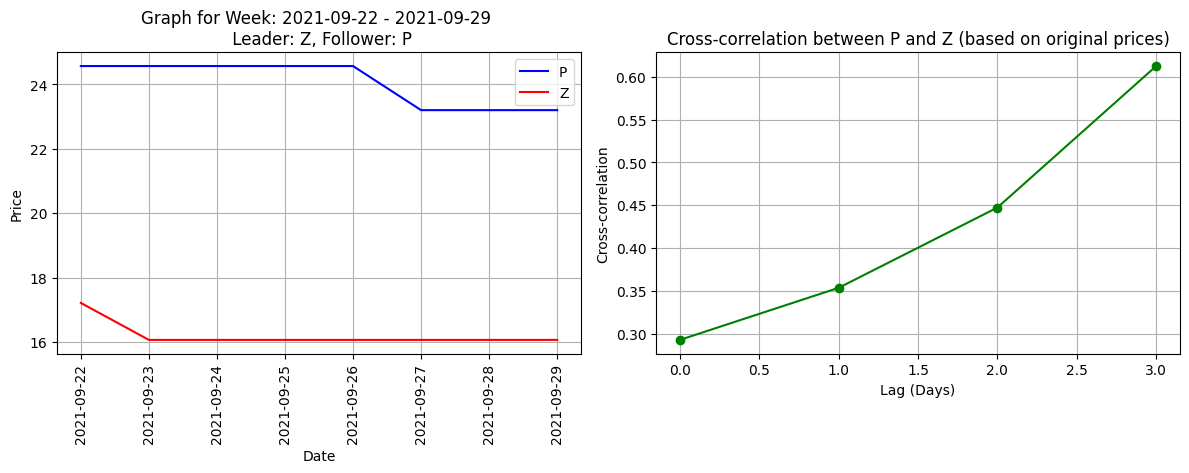

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: P and C

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
Correlation: 0.46
Lag: 1 days
Following: Leader: P, Follower: C



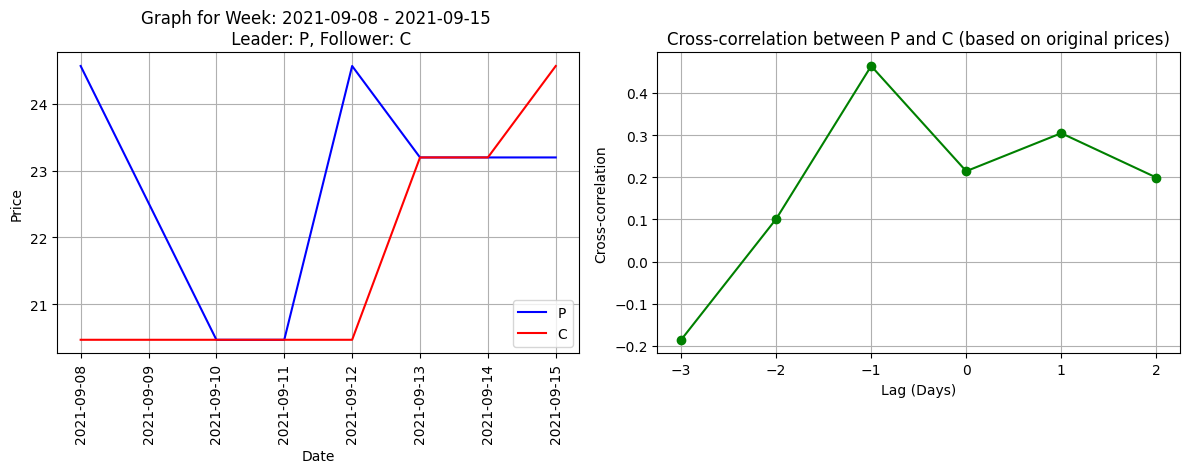

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: P and S

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
Correlation: 0.46
Lag: 1 days
Following: Leader: P, Follower: S



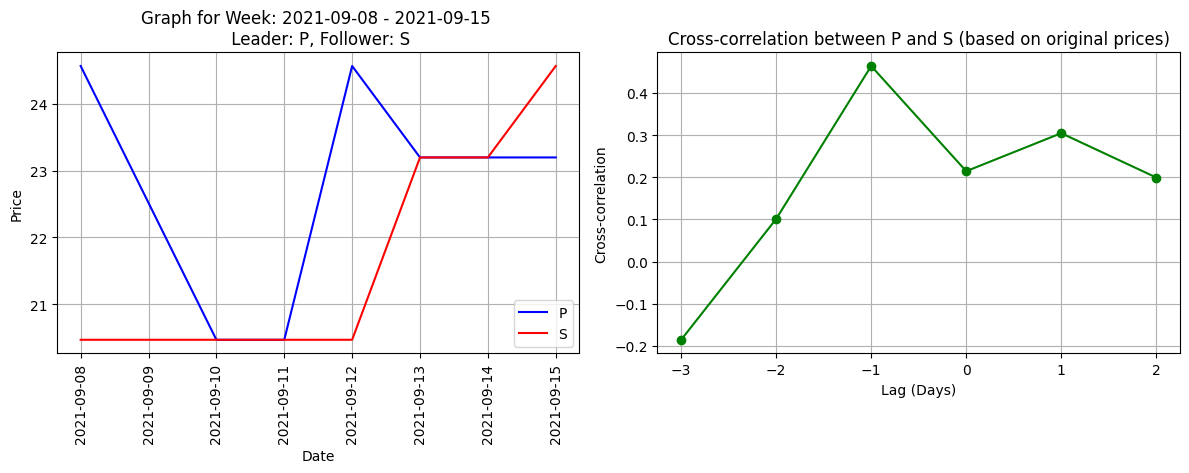

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: P and O

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
Correlation: 0.89
Lag: 2 days
Following: Leader: O, Follower: P



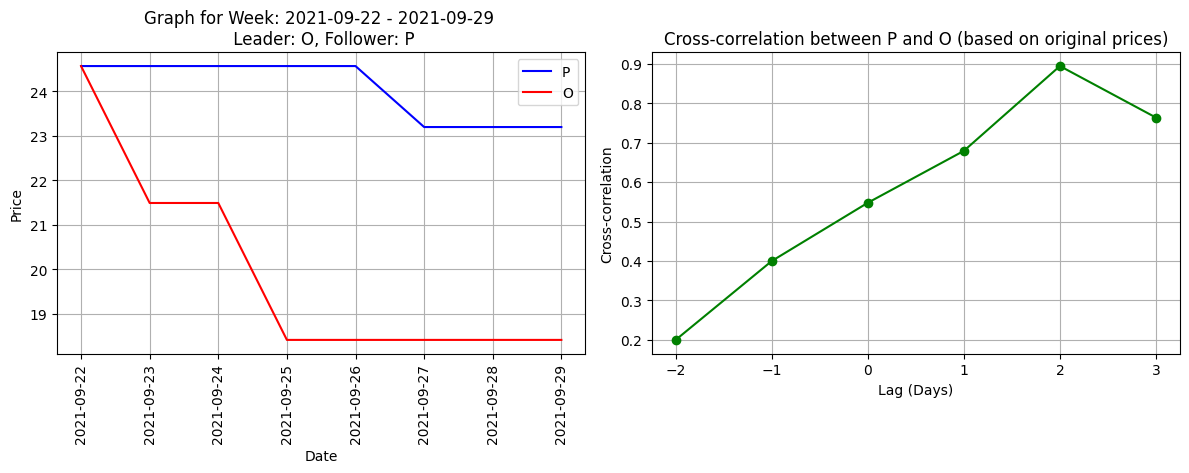

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
Correlation: 0.55
Lag: 1 days
Following: Leader: P, Follower: O



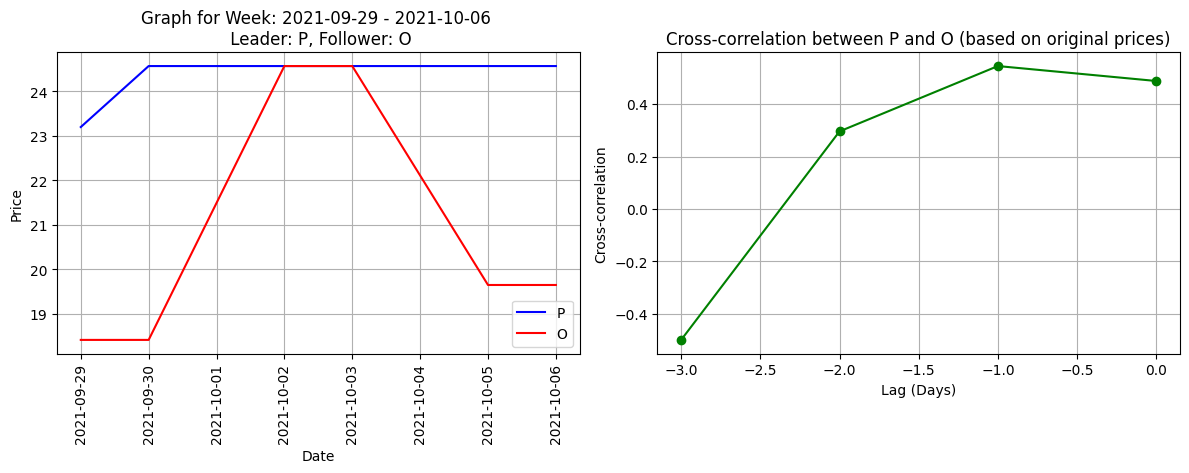

-------------------------

Seller Pair: P and I

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
Correlation: 1.00
Lag: 1 days
Following: Leader: P, Follower: I



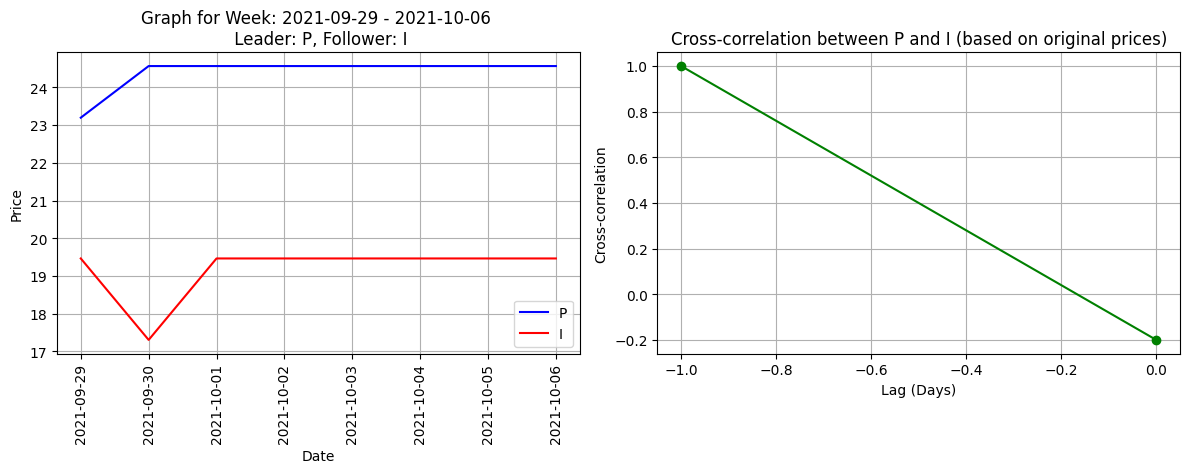

-------------------------

Seller Pair: P and T

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: P and E

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-29 to 2021-10-06
Corr

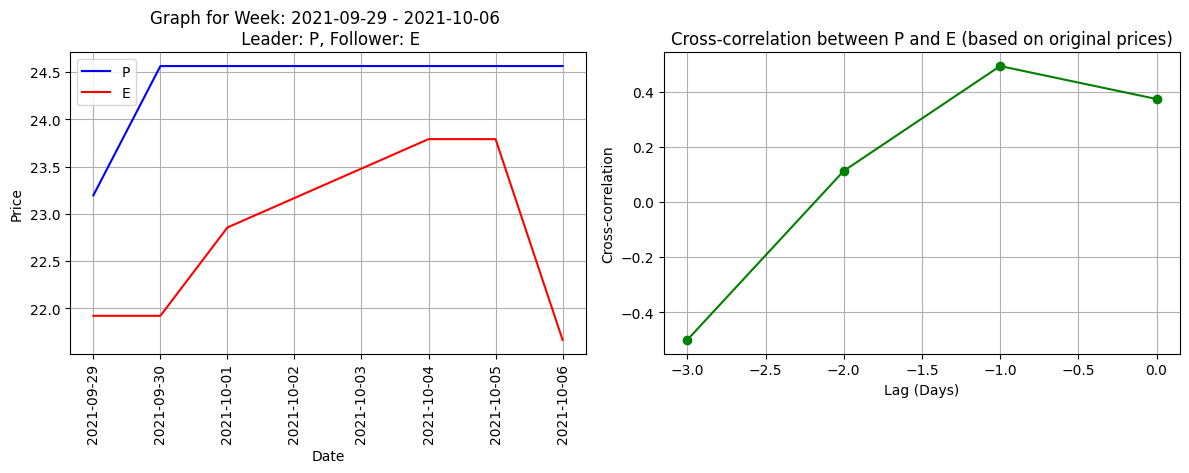

-------------------------

Seller Pair: Z and C

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
Correlation: 1.00
Lag: 1 days
Following: Leader: C, Follower: Z



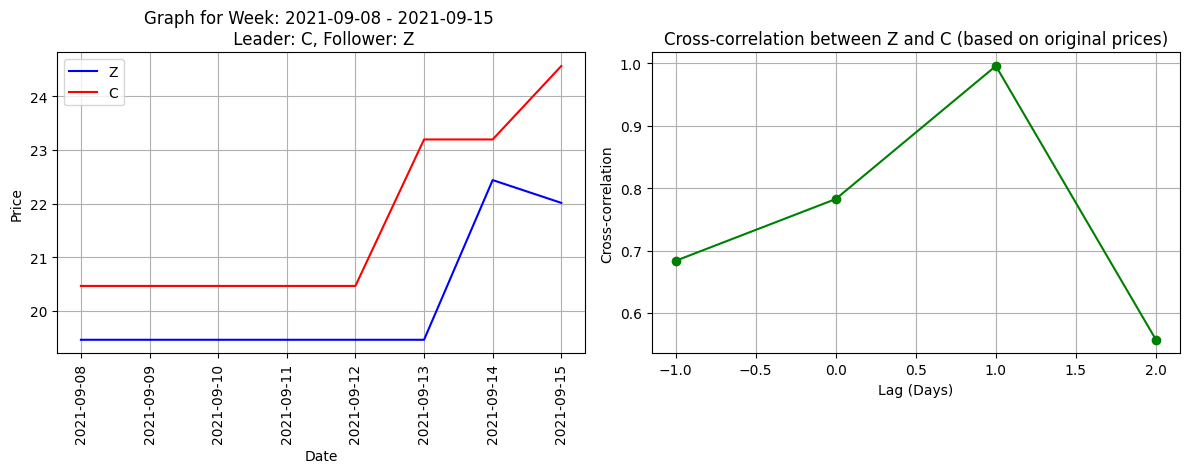

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: Z and S

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
Correlation: 1.00
Lag: 1 days
Following: Leader: S, Follower: Z



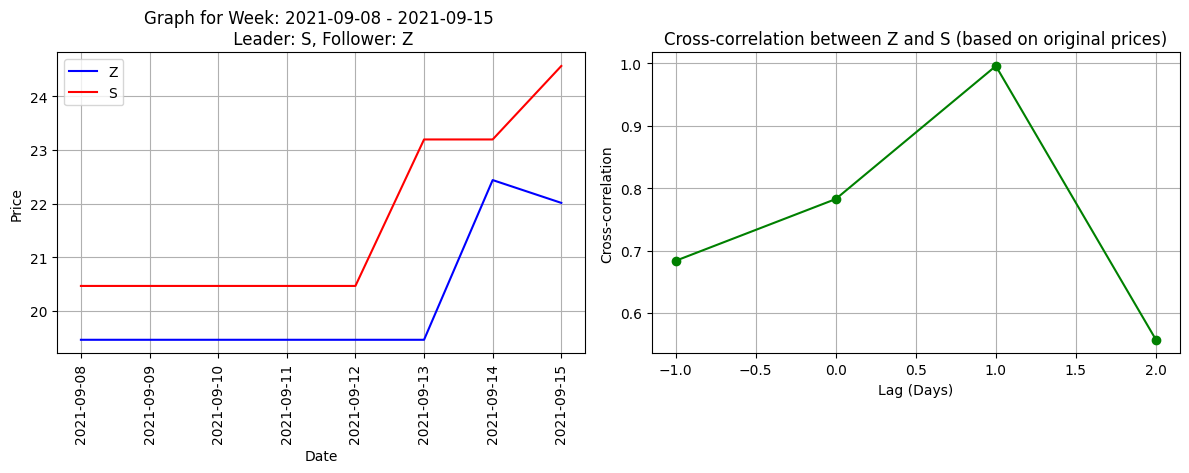

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: Z and O

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
Correlation: 1.00
Lag: 2 days
Following: Leader: Z, Follower: O



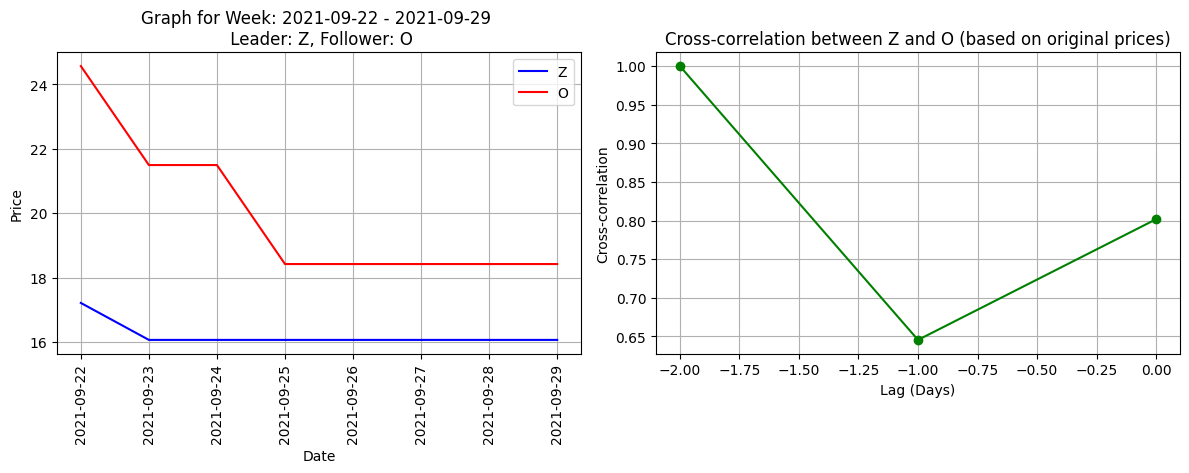

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: Z and I

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: Z and T

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis

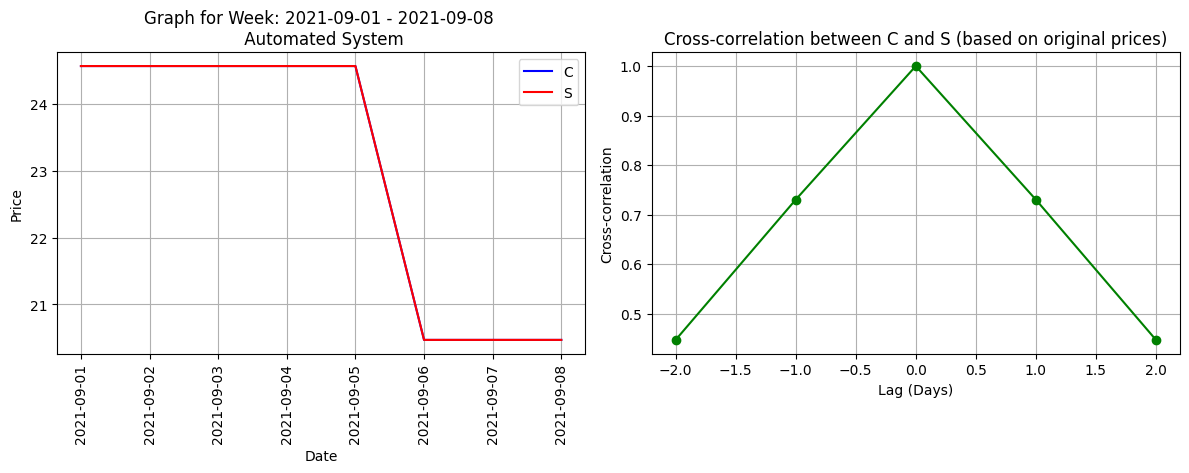

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
Correlation: 1.00
Lag: 0 days
Following: Automated System



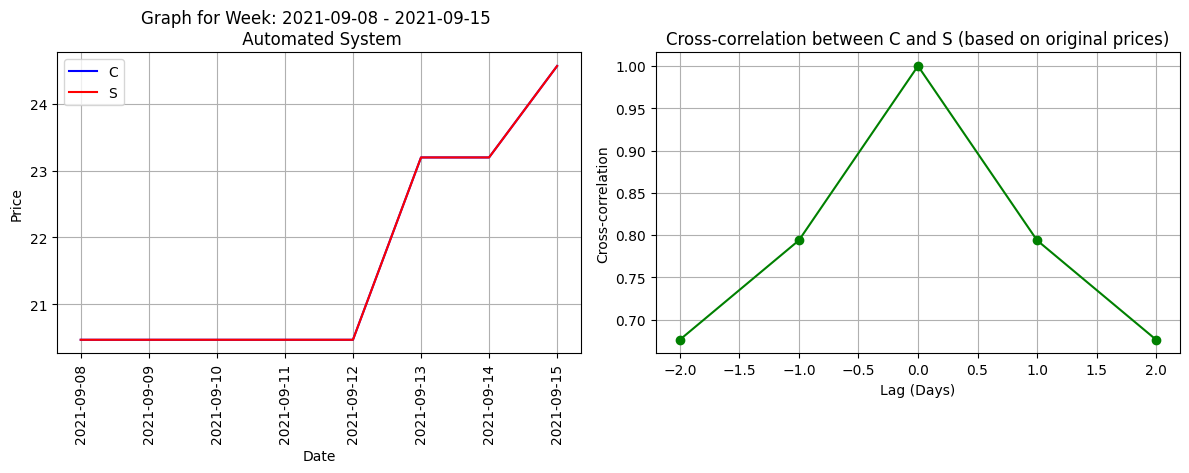

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: C and O

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: C and I

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis

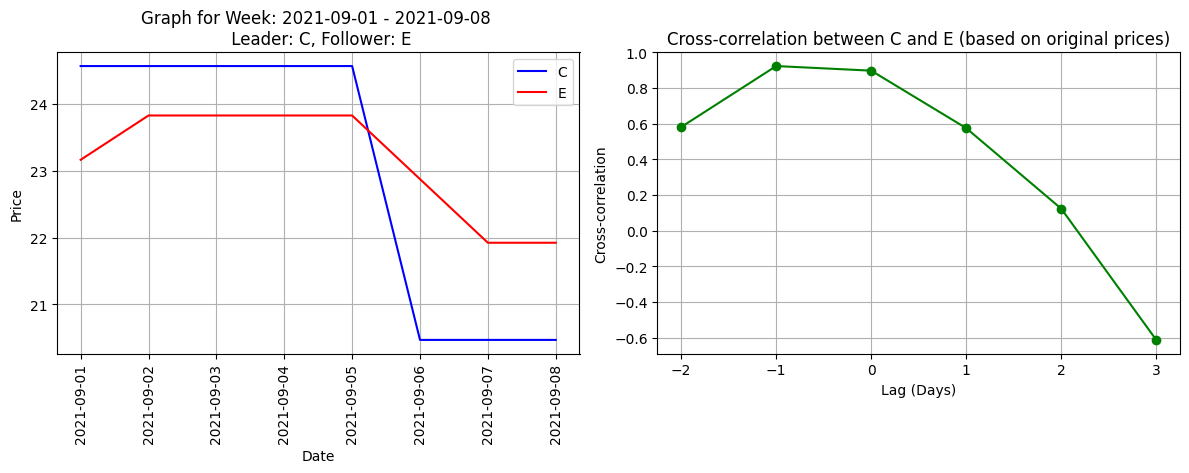

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: S and O

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: S and I

Timeframe: 2021-09-01 to 2021-09-08
Correlation Anal

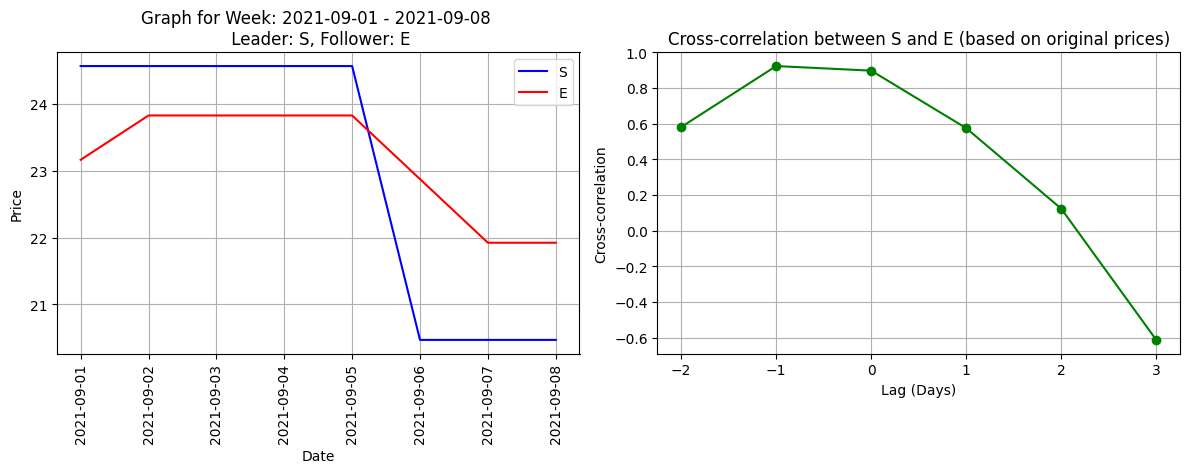

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: O and I

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
Correlation: 0.49
Lag: 1 days
Following: Leader: O, Follower: I



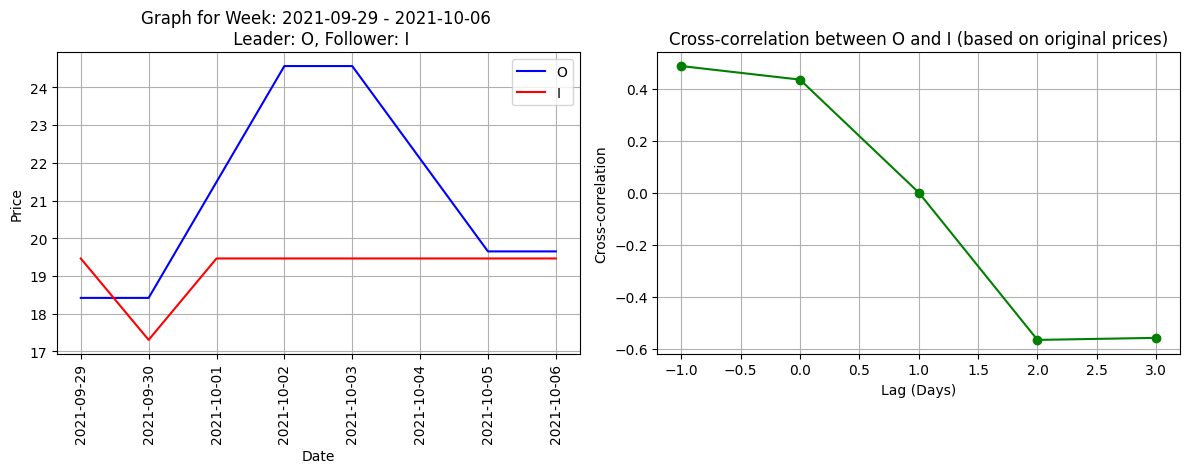

-------------------------

Seller Pair: O and T

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: O and E

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
The correlation is too low or negative

Timeframe: 2021-09-29 to 2021-10-06
Correlation Anal

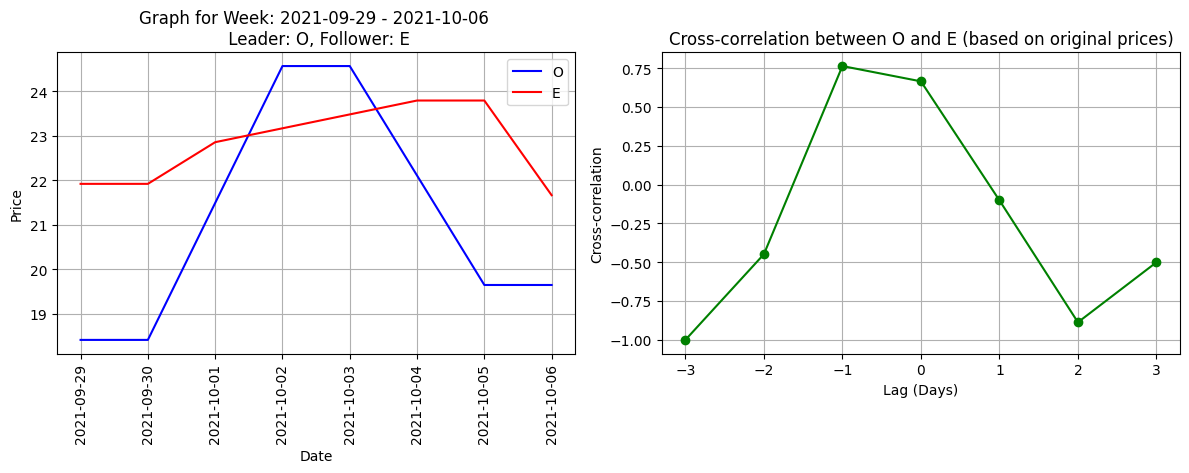

-------------------------

Seller Pair: I and T

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.

-------------------------

Seller Pair: I and E

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis

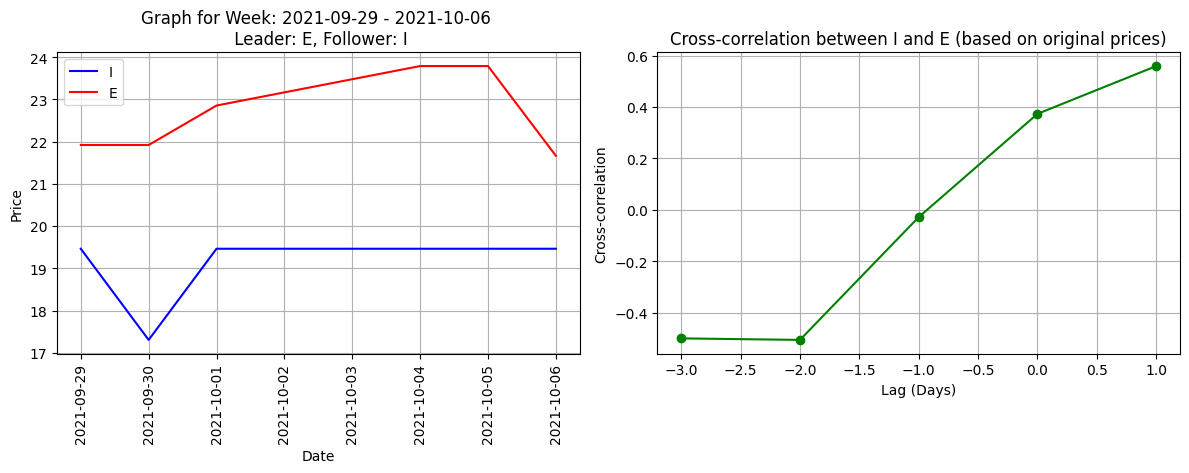

-------------------------

Seller Pair: T and E

Timeframe: 2021-09-01 to 2021-09-08
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-08 to 2021-09-15
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-15 to 2021-09-22
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-22 to 2021-09-29
Correlation Analysis:
No correlation in this time frame.

Timeframe: 2021-09-29 to 2021-10-06
Correlation Analysis:
No correlation in this time frame.



In [ ]:
# Get the correlation analysis with plot
seller_analysis.plot_correlations()

In [ ]:
# Get the correlation analysis with table

df = seller_analysis.table_leader_followers()
df

,Leader,2021-09-01 to 2021-09-08,2021-09-08 to 2021-09-15,2021-09-15 to 2021-09-22,2021-09-22 to 2021-09-29,2021-09-29 to 2021-10-06
0,E,NaN,P,"M, Z","M, P, O",I
1,T,NaN,NaN,NaN,NaN,NaN
2,I,NaN,NaN,NaN,NaN,NaN
3,Z,NaN,E,NaN,"P, O, E",NaN
4,O,NaN,NaN,NaN,P,"I, E"
5,P,M,"M, Z, C, S","M, Z, E",M,"O, I, E"
6,C,"M, E","Z, E",NaN,NaN,NaN
7,S,"M, E","Z, E",NaN,NaN,NaN
8,M,E,"Z, C, S, E",Z,O,"O, I, E"


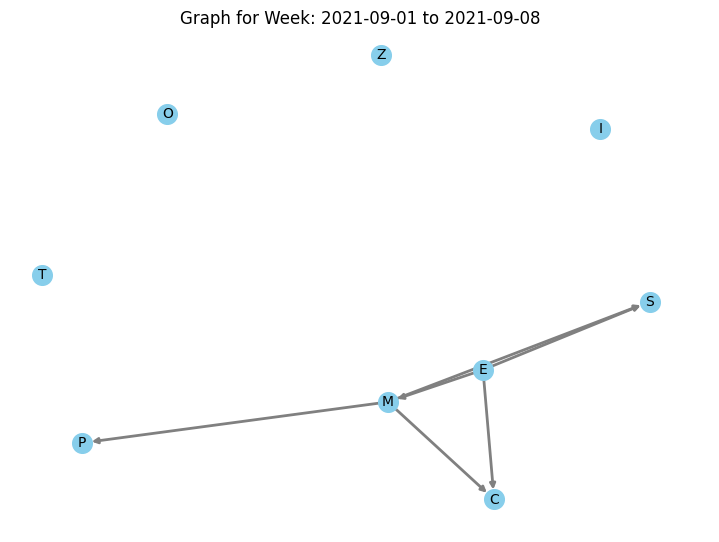

-------------------------------------------------------------------------------------


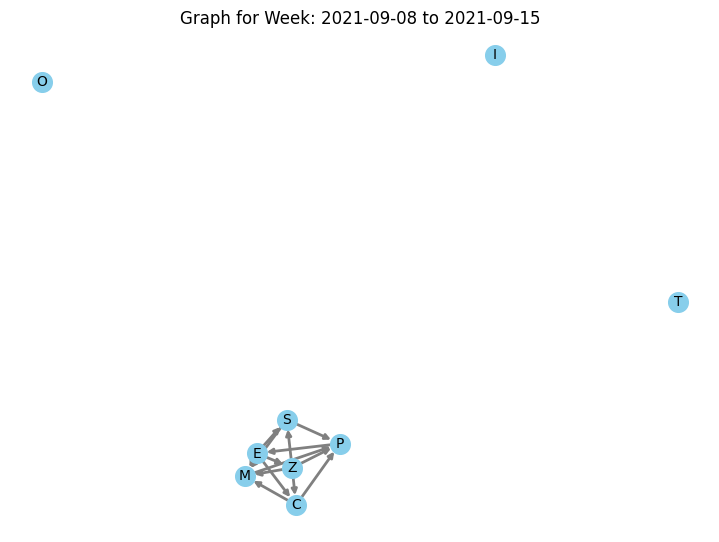

-------------------------------------------------------------------------------------


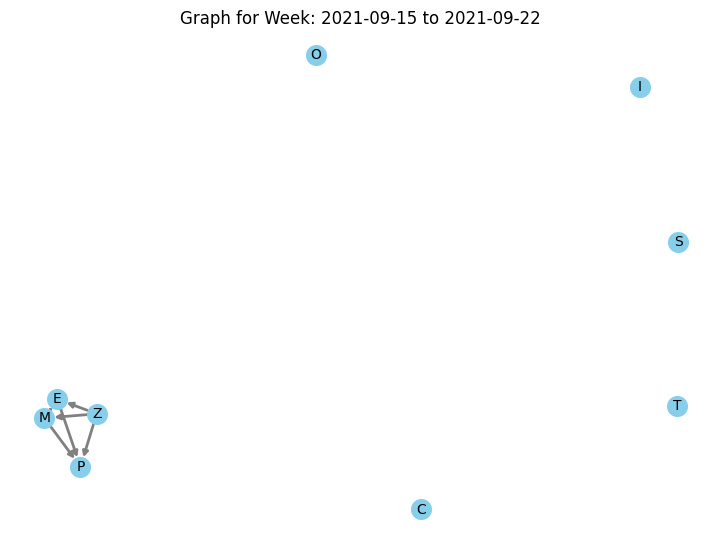

-------------------------------------------------------------------------------------


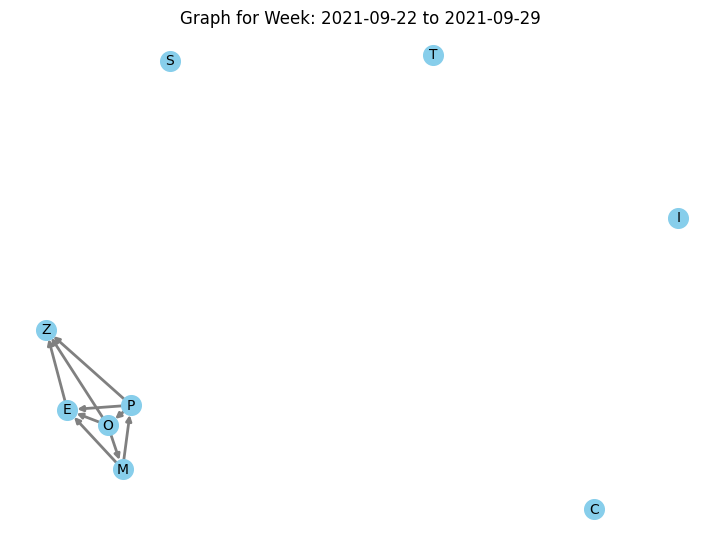

-------------------------------------------------------------------------------------


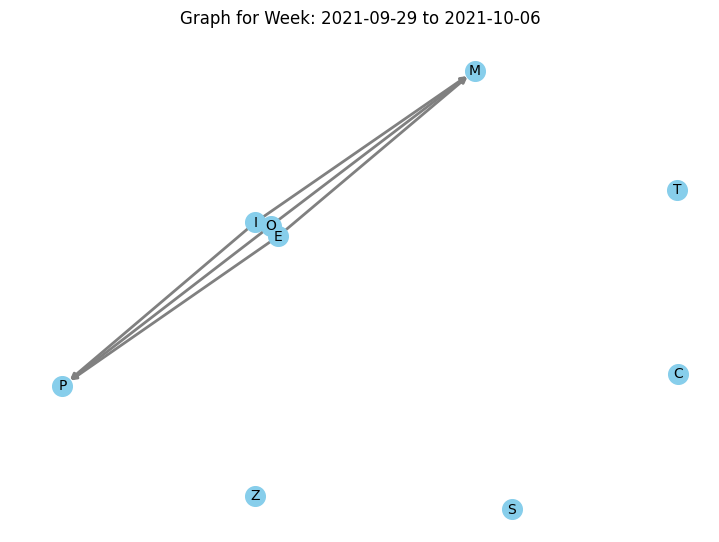

-------------------------------------------------------------------------------------


In [ ]:
# Get the Network Graphs

import networkx as nx
import matplotlib.pyplot as plt

week_columns = df.columns[1:]
week_leaders = {}
leaders_df = pd.DataFrame(columns=['Week', 'Leaders'])

def create_graph_for_week(week_column):
    """

    Creates a directed graph for a specific week based on leader-follower relationships.

    Parameters:
    - week_column (str): The column representing leader-follower relationships for a specific week.

    Returns:
    - G (nx.DiGraph): A directed graph representing leader-follower relationships.

    """
    G = nx.DiGraph()
    for index, row in df.iterrows():
        leader = row['Leader']
        G.add_node(leader)
        if pd.notna(row[week_column]):
            followers = row[week_column].split(',')
            for follower in followers:
                follower = follower.strip()
                G.add_node(follower)
                G.add_edge(follower, leader)
    return G


# Iterate through each week in the provided DataFrame
for week in week_columns:

    # Create a directed graph for the current week
    G_week = create_graph_for_week(week)

    # Calculate in-degrees for each node in the graph
    in_degrees = G_week.in_degree()

    # Find the maximum in-degree value
    max_in_degree = max(in_degrees, key=lambda item: item[1])[1]

    # Identify leaders with the maximum in-degree for the current week
    week_leaders[week] = [node for node, degree in in_degrees if degree == max_in_degree]

    # Update leaders_df with the leaders for the current week
    leaders_df = leaders_df.append({'Week': week, 'Leaders': ', '.join(week_leaders[week])}, ignore_index=True)

    # Visualize the leader-follower network for the current week
    plt.figure(figsize=(7, 5))
    pos = nx.spring_layout(G_week)
    nx.draw(G_week, pos, with_labels=True, node_color='skyblue', node_size=200, font_size=10, width=2, edge_color='gray', arrows=True, arrowsize=8)

    # Add title and display the graph for the current week
    plt.title(f"Graph for Week: {week}")
    plt.show()

    # Print a separator for better output visibility
    print('-' * 85)


In [ ]:
# Create a DataFrame to store the leaders for each week
leaders_data = []
for week, leaders in week_leaders.items():
    leaders_data.append({'Week': week, 'Leaders': leaders})

leaders_df = pd.DataFrame(leaders_data)

# Print the DataFrame
print(leaders_df)

                       Week Leaders
0  2021-09-01 to 2021-09-08  [C, S]
1  2021-09-08 to 2021-09-15  [P, M]
2  2021-09-15 to 2021-09-22     [P]
3  2021-09-22 to 2021-09-29  [E, Z]
4  2021-09-29 to 2021-10-06  [P, M]


# TASK 2 RELEVANT PRODUCTS

## define the perimeter

In [ ]:
# take only the data of the seller 576, cause we want to define a new catalog for this seller
df_task_2 = prices_competitor
df_task_2 = df_task_2.filter(df_task_2["seller_id"] == 576)

In [ ]:
from pyspark.sql import functions as F

# Join sales_data with prices_competitors on product_id and date
sales_data_576 = sales_data.join(df_task_2, (sales_data["product_id"] == df_task_2["product_id"]) & (sales_data["sale_date"] == df_task_2["comp_date"])).drop(df_task_2["product_id"])
# check if sales_price_tax of sales_data and price of price_competitors match to make sure the join is done right


In [ ]:
#prendiamo solo il 2021
sales_data_576_2021 = sales_data_576.filter((sales_data_576["sale_date"] >= "2021-01-01") & (sales_data_576["sale_date"] <= "2021-12-31"))


In [ ]:
# Primo Trimestre (Gennaio - Marzo)
sales_data_576_Q1 = sales_data_576.filter((sales_data_576["sale_date"] >= "2021-01-01") & (sales_data_576["sale_date"] <= "2021-03-31"))

# Secondo Trimestre (Aprile - Giugno)
sales_data_576_Q2 = sales_data_576.filter((sales_data_576["sale_date"] >= "2021-04-01") & (sales_data_576["sale_date"] <= "2021-06-30"))

# Terzo Trimestre (Luglio - Settembre)
sales_data_576_Q3 = sales_data_576.filter((sales_data_576["sale_date"] >= "2021-07-01") & (sales_data_576["sale_date"] <= "2021-09-30"))

# Quarto Trimestre (Ottobre - Dicembre)
sales_data_576_Q4 = sales_data_576.filter((sales_data_576["sale_date"] >= "2021-10-01") & (sales_data_576["sale_date"] <= "2021-12-31"))

# Quarto Trimestre (Ottobre - Dicembre)
sales_data_576_BF = sales_data_576.filter((sales_data_576["sale_date"] >= "2021-11-01") & (sales_data_576["sale_date"] <= "2021-11-30"))



In [ ]:
# Put all the sales data for each quarter and black friday, we're gonna use this list for the plots
Sales_data_list = [sales_data_576_Q1,
                   sales_data_576_Q2,
                   sales_data_576_Q3,
                   sales_data_576_Q4,
                   sales_data_576_BF]

In [ ]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, sum as _sum

def calculate_totals(dataframes):
    old_catalog_sales = []
    old_catalog_net_profit = []

    for df in dataframes:
        # add the column 'net_profit'
        df_with_net_profit = df.withColumn("net_profit", col("sales_price") - col("purchase_price"))

        # compute the total of 'sales_price'
        total_sales = df_with_net_profit.agg(_sum("sales_price").alias("TotalSales")).collect()[0][0]

        # compute the total of 'net_profit'
        total_net_profit = df_with_net_profit.agg(_sum("net_profit").alias("TotalNetProfit")).collect()[0][0]

        # add the totals to each respective list, we're gonna use these lists for the plots
        old_catalog_sales.append(total_sales)
        old_catalog_net_profit.append(total_net_profit)

    return old_catalog_sales, old_catalog_net_profit

# Calculating sales_price and net_profit totals for each DataFrame.
old_catalog_sales, old_catalog_net_profit = calculate_totals(Sales_data_list)

# print the results
for i, (sales, net_profit) in enumerate(zip(old_catalog_sales, old_catalog_net_profit)):
    print(f"Old_catalog_Q{i+1} - Totale Sales: {sales}, Totale Net Profit: {net_profit}")


Old_catalog_Q1 - Totale Sales: 2857400.664000248, Totale Net Profit: 218823.13674950754
Old_catalog_Q2 - Totale Sales: 2811665.9040000644, Totale Net Profit: 225212.15763406124
Old_catalog_Q3 - Totale Sales: 3277766.6425002655, Totale Net Profit: 219264.16835736987
Old_catalog_Q4 - Totale Sales: 3108741.66900017, Totale Net Profit: 265394.5633596567
Old_catalog_Q5 - Totale Sales: 1174869.7704999887, Totale Net Profit: 95884.70587930575


In [ ]:
print(old_catalog_net_profit)
print(old_catalog_sales)

[218823.13674950754, 225212.15763406124, 219264.16835736987, 265394.5633596567, 95884.70587930575]
[2857400.664000248, 2811665.9040000644, 3277766.6425002655, 3108741.66900017, 1174869.7704999887]


# most relevant for net_profit

COMPUTE THE MOST RELEVANT FOR NET PROFIT OF PRODUCTS

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as _sum
from pyspark.sql.functions import desc

def most_relevant_product_for_profit(df):
    # We drop date rooms to avoid problems during groupbys, we already have one date column.
    df = df.drop('sale_date')
    # compute the net profit for each purchase
    df = df.withColumn("net_profit", F.col("sales_price") - F.col("purchase_price"))

    # We calculate the sum net_profit and the sum purchase_price for each product_id
    df = df.groupBy("product_id").agg(
        F.sum("net_profit").alias("total_net_profit_per_product"),
        F.sum("purchase_price").alias("total_cost_per_product"),
        F.sum("sales_price").alias("total_sales_per_prouct")
    )

    # Ordiniamo in base al total_net_profit_per_product in ordine discendente
    df = df.orderBy(F.desc("total_net_profit_per_product"))

    # We sort by total_net_profit_per_product in descending order.
    total_profit_result = df.agg(F.sum("total_net_profit_per_product").alias("total_profit"))

    # We extract the total value of net profit.
    total_net_profit = total_profit_result.collect()[0]["total_profit"]
    total_cost_result = df.agg(F.sum("total_cost_per_product").alias("total_cost"))
    total_cost = total_cost_result.collect()[0]["total_cost"]

    # We add the column with the percentage of net_profit of each product to the total
    df = df.withColumn("percent_of_total", (F.col("total_net_profit_per_product") / total_net_profit) * 100)

    # We define a sorting window based on the percent_of_total column.
    windowSpec = Window.orderBy(F.desc("percent_of_total")).rangeBetween(Window.unboundedPreceding, 0)

    # Let's add the column with the cumulative percentage.
    df = df.withColumn("cumulative_percentage_of_profit", F.sum("percent_of_total").over(windowSpec))

    return df, total_net_profit, total_cost

Chiamiamo la funzione per trovare la percentuale cumulata di sales per prodotto

In [ ]:
#call the function to get the new relevant product for net profit for each quarter and black friday
most_relevant_for_profit_Q1, total_net_profit_Q1, old_catalog_cost_Q1 = most_relevant_product_for_profit(sales_data_576_Q1)
most_relevant_for_profit_Q2, total_net_profit_Q2, old_catalog_cost_Q2 = most_relevant_product_for_profit(sales_data_576_Q2)
most_relevant_for_profit_Q3, total_net_profit_Q3, old_catalog_cost_Q3 = most_relevant_product_for_profit(sales_data_576_Q3)
most_relevant_for_profit_Q4, total_net_profit_Q4, old_catalog_cost_Q4 = most_relevant_product_for_profit(sales_data_576_Q4)
most_relevant_for_profit_BF, total_net_profit_BF, old_catalog_cost_BF = most_relevant_product_for_profit(sales_data_576_BF)

In [ ]:
# number of products check
distinct_product_Q1 = most_relevant_for_profit_Q1.select("product_id").distinct().count()
distinct_product_Q2 = most_relevant_for_profit_Q2.select("product_id").distinct().count()
distinct_product_Q3 = most_relevant_for_profit_Q3.select("product_id").distinct().count()
distinct_product_Q4 = most_relevant_for_profit_Q4.select("product_id").distinct().count()
distinct_product_BF = most_relevant_for_profit_BF.select("product_id").distinct().count()

print("Il numero di product_id distinti nel Q1 è", distinct_product_Q1)
print("Il numero di product_id distinti nel Q2 è", distinct_product_Q2)
print("Il numero di product_id distinti nel Q3 è", distinct_product_Q3)
print("Il numero di product_id distinti nel Q4 è", distinct_product_Q4)
print("Il numero di product_id distinti nel Black Friday è", distinct_product_BF)

Il numero di product_id distinti nel Q1 è 4022
Il numero di product_id distinti nel Q2 è 4383
Il numero di product_id distinti nel Q3 è 4392
Il numero di product_id distinti nel Q4 è 4467
Il numero di product_id distinti nel Black Friday è 3214


In [ ]:
#put the results in to lists that we are gonna use for the plot
total_initial_profit_list = [total_net_profit_Q1,
                             total_net_profit_Q2,
                             total_net_profit_Q3,
                             total_net_profit_Q4,
                             total_net_profit_BF]

old_catalog_cost_list = [old_catalog_cost_Q1,
                         old_catalog_cost_Q2,
                         old_catalog_cost_Q3,
                         old_catalog_cost_Q4,
                         old_catalog_cost_BF]

In [ ]:
print(total_initial_profit_list)
print(old_catalog_cost_list)

[218823.13674950346, 225212.1576340625, 219264.16835737095, 265394.5633596569, 95884.70587930577]
[2638577.5272504906, 2586453.74636593, 3058502.474142632, 2843347.1056403494, 1078985.0646206944]


# COMPARISON WITH SELLER 1681 DATA

We make this comparison in order to check which are the most profitable products of the market leader but that our seller isn't selling right now.

Then we are gonna add these products to our new final catalog

In [ ]:
# take only data of seller 1681
df_task_2_1681 = prices_competitor.filter(prices_competitor["seller_id"] == 1681)

In [ ]:
# filter for the year 2021
sales_data_576_2021 = sales_data_576.filter((sales_data_576["sale_date"] >= "2021-01-01") & (sales_data_576["sale_date"] <= "2021-12-31"))
# Join sales_data with prices_competitors on product_id and date
sales_data_1681 = sales_data.join(df_task_2_1681, (sales_data["product_id"] == df_task_2_1681["product_id"]) & (sales_data["sale_date"] == df_task_2_1681["comp_date"])).drop(df_task_2_1681["product_id"])
sales_data_1681_2021 = sales_data_1681.filter((sales_data_1681["sale_date"] >= "2021-01-01") & (sales_data_1681["sale_date"] <= "2021-12-31"))
# check if sales_price_tax of sales_data and price of price_competitors match to make sure the join is done right

In [ ]:
def most_relevant_product_for_profit_1681(df):
    # We drop date rooms to avoid problems during groupbys, we already have one date column.
    #df = df.drop('sale_date')
    # compute the net profit for each purchase
    df = df.withColumn("net_profit", F.col("sales_price") - F.col("purchase_price"))

    # We calculate the sum net_profit and the sum purchase_price for each product_id
    df = df.groupBy("product_id").agg(
        F.sum("net_profit").alias("total_net_profit_per_product"),
        F.sum("purchase_price").alias("total_cost_per_product"),
        F.sum("sales_price").alias("total_sales_per_product")
    )

    # Ordiniamo in base al total_net_profit_per_product in ordine discendente
    df = df.orderBy(F.desc("total_net_profit_per_product"))

    # We sort by total_net_profit_per_product in descending order.
    total_profit_result = df.agg(F.sum("total_net_profit_per_product").alias("total_profit"))

    # We extract the total value of net profit.
    total_net_profit = total_profit_result.collect()[0]["total_profit"]
    total_cost_result = df.agg(F.sum("total_cost_per_product").alias("total_cost"))
    total_cost = total_cost_result.collect()[0]["total_cost"]

    # We add the column with the percentage of net_profit of each product to the total
    df = df.withColumn("percent_of_total", (F.col("total_net_profit_per_product") / total_net_profit) * 100)

    # We define a sorting window based on the percent_of_total column.
    windowSpec = Window.orderBy(F.desc("percent_of_total")).rangeBetween(Window.unboundedPreceding, 0)

    # Let's add the column with the cumulative percentage.
    df = df.withColumn("cumulative_percentage_of_profit", F.sum("percent_of_total").over(windowSpec))

    return df, total_net_profit

In [ ]:
# Primo Trimestre (Gennaio - Marzo)
sales_data_1681_Q1 = sales_data_1681.filter((sales_data_1681["sale_date"] >= "2021-01-01") & (sales_data_1681["sale_date"] <= "2021-03-31"))

# Secondo Trimestre (Aprile - Giugno)
sales_data_1681_Q2 = sales_data_1681.filter((sales_data_1681["sale_date"] >= "2021-04-01") & (sales_data_1681["sale_date"] <= "2021-06-30"))

# Terzo Trimestre (Luglio - Settembre)
sales_data_1681_Q3 = sales_data_1681.filter((sales_data_1681["sale_date"] >= "2021-07-01") & (sales_data_1681["sale_date"] <= "2021-09-30"))

# Quarto Trimestre (Ottobre - Dicembre)
sales_data_1681_Q4 = sales_data_1681.filter((sales_data_1681["sale_date"] >= "2021-10-01") & (sales_data_1681["sale_date"] <= "2021-12-31"))

# Quarto Trimestre (Ottobre - Dicembre)
sales_data_1681_BF = sales_data_1681.filter((sales_data_1681["sale_date"] >= "2021-11-01") & (sales_data_1681["sale_date"] <= "2021-11-30"))


In [ ]:
#calculate the most relevant with cumulative percentage
most_relevant_for_profit_1681_Q1, total_net_profit_1681_Q1 = most_relevant_product_for_profit_1681(sales_data_1681_Q1)
most_relevant_for_profit_1681_Q2, total_net_profit_1681_Q2 = most_relevant_product_for_profit_1681(sales_data_1681_Q2)
most_relevant_for_profit_1681_Q3, total_net_profit_1681_Q3 = most_relevant_product_for_profit_1681(sales_data_1681_Q3)
most_relevant_for_profit_1681_Q4, total_net_profit_1681_Q4 = most_relevant_product_for_profit_1681(sales_data_1681_Q4)
most_relevant_for_profit_1681_BF, total_net_profit_1681_BF = most_relevant_product_for_profit_1681(sales_data_1681_BF)
# take only the first 400
new_most_relevant_for_profit_1681_Q1 = most_relevant_for_profit_1681_Q1.limit(400)
new_most_relevant_for_profit_1681_Q2 = most_relevant_for_profit_1681_Q2.limit(400)
new_most_relevant_for_profit_1681_Q3 = most_relevant_for_profit_1681_Q3.limit(400)
new_most_relevant_for_profit_1681_Q4 = most_relevant_for_profit_1681_Q4.limit(400)
new_most_relevant_for_profit_1681_BF = most_relevant_for_profit_1681_BF.limit(400)

In [ ]:
# put the results into a list that we are gonna use for the plot
total_net_profit_1681_list = [new_most_relevant_for_profit_1681_Q1,
                              new_most_relevant_for_profit_1681_Q2,
                              new_most_relevant_for_profit_1681_Q3,
                              new_most_relevant_for_profit_1681_Q4,
                              new_most_relevant_for_profit_1681_BF]

In [ ]:
def calculate_totals_1681(df_list):
    total_net_profit = []
    total_cost = []
    total_sales = []

    for df in df_list:
        totals = df.agg(
            F.sum("total_net_profit_per_product").alias("total_net_profit"),
            F.sum("total_cost_per_product").alias("total_cost"),
            F.sum("total_sales_per_product").alias("total_sales")
        ).collect()[0]

        total_net_profit.append(totals["total_net_profit"])
        total_cost.append(totals["total_cost"])
        total_sales.append(totals["total_sales"])

    return total_net_profit, total_cost, total_sales

# call the function
total_net_profit_1681_list, total_cost_1681_list, total_sales_1681_list = calculate_totals_1681(total_net_profit_1681_list)

In [ ]:
# Select distinct 'product_id' values
distinct_product_ids_1681 = new_most_relevant_for_profit_1681_Q1.select("product_id").distinct()
# Collect these values into a list
distinct_product_ids_list_1681 = [row['product_id'] for row in distinct_product_ids_1681.collect()]
# Select distinct 'product_id' values
distinct_product_ids_560 = new_most_relevant_for_profit_Q1.select("product_id").distinct()
# Collect these values into a list
distinct_product_ids_list_560 = [row['product_id'] for row in distinct_product_ids_560.collect()]

#unique products in distinct_product_ids_list_1681: These are the products in distinct_product_ids_list_1681 but not in distinct_product_ids_list_560
in_1681_not_in_576 = set(distinct_product_ids_list_1681) - set(distinct_product_ids_list_560)

In [ ]:
# Convert 'in_1681_not_in_576' to a list of tuples
product_ids_tuples = [(product_id,) for product_id in in_1681_not_in_576]

# Create an RDD from your list of tuples.
rdd = spark.sparkContext.parallelize(product_ids_tuples)

# Convert the RDD to a DataFrame.
prodotti_non_in_560 = rdd.toDF(["product_id"])

In [ ]:
# join each dataframe in order to get only a df with the products that the 560 don't sell
joined_df_Q1 = new_most_relevant_for_profit_1681_Q1.join(prodotti_non_in_560, "product_id", "inner")
joined_df_Q2 = new_most_relevant_for_profit_1681_Q2.join(prodotti_non_in_560, "product_id", "inner")
joined_df_Q3 = new_most_relevant_for_profit_1681_Q3.join(prodotti_non_in_560, "product_id", "inner")
joined_df_Q4 = new_most_relevant_for_profit_1681_Q4.join(prodotti_non_in_560, "product_id", "inner")
joined_df_BF = new_most_relevant_for_profit_1681_BF.join(prodotti_non_in_560, "product_id", "inner")

In [ ]:
#calculate the totals of sales,cost and net profit for each joined_df
#we are gonna add these values to the new catalog based on the most profitable products
#so we will have in the catalog also the most profitable products of the market leader that we don't sell
def calculate_totals_for_each_df(df_list):
    all_total_costs = []
    all_total_sales = []
    all_total_net_profits = []

    for df in df_list:
        totals = df.agg(
            F.sum("total_cost_per_product").alias("total_cost"),
            F.sum("total_sales_per_product").alias("total_sales"),
            F.sum("total_net_profit_per_product").alias("total_net_profit")
        ).collect()[0]

        all_total_costs.append(totals["total_cost"])
        all_total_sales.append(totals["total_sales"])
        all_total_net_profits.append(totals["total_net_profit"])

    return all_total_costs, all_total_sales, all_total_net_profits

# Crea una lista di tutti i DataFrame joinati
joined_df_list = [joined_df_Q1, joined_df_Q2, joined_df_Q3, joined_df_Q4, joined_df_BF]

# Utilizza la funzione sulla lista di DataFrame
total_costs_list_1681, total_sales_list_1681, total_net_profits_list_1681 = calculate_totals_for_each_df(joined_df_list)


# NEW FINAL CATALOG

We take only the 10% of the products, and this 10% constitutes abput the 60$ of the total sales




In [ ]:
# take just the 10% of products of the total catalog, they represent 56% of total profit most_relevant_for_profit_Q1 = most_relevant_for_profit_Q1.limit(1000)
new_most_relevant_for_profit_Q1 = most_relevant_for_profit_Q1.limit(400)
new_most_relevant_for_profit_Q2 = most_relevant_for_profit_Q2.limit(400)
new_most_relevant_for_profit_Q3 = most_relevant_for_profit_Q3.limit(400)
new_most_relevant_for_profit_Q4 = most_relevant_for_profit_Q4.limit(400)
new_most_relevant_for_profit_BF = most_relevant_for_profit_BF.limit(400)



put each list of relevant products into a list

In [ ]:
most_relevant_for_profit_list = [new_most_relevant_for_profit_Q1,
                                 new_most_relevant_for_profit_Q2,
                                 new_most_relevant_for_profit_Q3,
                                 new_most_relevant_for_profit_Q4,
                                 new_most_relevant_for_profit_BF]

Let's do the join so we can have our new **catalog**.
In this way we have in the new catalog only products that meet both of our relevance criteria



Compute the total profit of the new catalog and put them in to a list that we are gonna use for the plot

In [ ]:
# List to store totals of total_net_profit_per_product for each DataFrame
New_catalog_net_profit_per_quarter = []

for df in most_relevant_for_profit_list:
    # Calculates the total_net_profit_per_product for the current DataFrame
    total = df.agg(F.sum("total_net_profit_per_product").alias("total_profit")).collect()[0]["total_profit"]
    New_catalog_net_profit_per_quarter.append(total)

# List to store totals of total_net_profit_per_product for each DataFrame
New_catalog_sales_per_quarter = []

for df in most_relevant_for_profit_list:
    # It calculates the total sales per product for the current DataFrame
    total = df.agg(F.sum("total_sales_per_prouct").alias("total_sales")).collect()[0]["total_sales"]
    New_catalog_sales_per_quarter.append(total)

In [ ]:
# List to store the count of distinct products for each DataFrame
new_catalog_distinct_product_counts = []

for df in most_relevant_for_profit_list:
    # Calculate the number of distinct products in the current DataFrame
    distinct_count = df.select("product_id").distinct().count()
    new_catalog_distinct_product_counts.append(distinct_count)

**Calculate the profit percentage of the new catalog compared with the initial one**.

In [ ]:
quarters = ['Q1', 'Q2', 'Q3', 'Q4','Black Friday']  # Name of Quarters

# Calculate and print the percentage of profits from the new catalogue compared to the initial profits for each quarter
for quarter, new_profit, initial_profit in zip(quarters, New_catalog_net_profit_per_quarter, total_initial_profit_list):
    percentage = (new_profit / initial_profit) * 100 if initial_profit != 0 else 0
    print(f"Percentuale di profitti del nuovo catalogo rispetto ai profitti iniziali {quarter}: {percentage:.2f}%")

Percentuale di profitti del nuovo catalogo rispetto ai profitti iniziali Q1: 63.64%
Percentuale di profitti del nuovo catalogo rispetto ai profitti iniziali Q2: 60.27%
Percentuale di profitti del nuovo catalogo rispetto ai profitti iniziali Q3: 64.87%
Percentuale di profitti del nuovo catalogo rispetto ai profitti iniziali Q4: 61.06%
Percentuale di profitti del nuovo catalogo rispetto ai profitti iniziali Black Friday: 72.62%


In [ ]:
# List to store totals of total_cost_per_product for each DataFrame
New_catalog_costs = []

for df in most_relevant_for_profit_list:
    # Calculates the total_cost_per_product for the current DataFrame
    total_cost_result = df.agg(F.sum("total_cost_per_product").alias("total_cost"))
    total_cost = total_cost_result.collect()[0]["total_cost"]
    New_catalog_costs.append(total_cost)


In [ ]:
# Calculating the difference between the elements of the two lists
new_catalog_profit = [sale - cost for sale, cost in zip(New_catalog_sales_per_quarter, New_catalog_costs)]

old_catalog_profit = [sale - cost for sale, cost in zip(old_catalog_sales, old_catalog_cost_list)]

In [ ]:
#calculate the totals of the new catalog including the product of 1681 that we don't sale
new_catalog_with_1681_sales = [sale1 + sale2 for sale1, sale2 in zip(New_catalog_sales_per_quarter, total_sales_list_1681)]
new_catalog_with_1681_cost = [cost1 + cost2 for cost1, cost2 in zip(New_catalog_costs, total_costs_list_1681)]

In [ ]:
# calculate the profit of the new final catalog
new_catalog_profit = [sale - cost for sale, cost in zip(new_catalog_with_1681_sales, New_catalog_costs)]

**PLOT COST COMPARISON BETWEEN THE OLD AND THE NEW CATALOG**

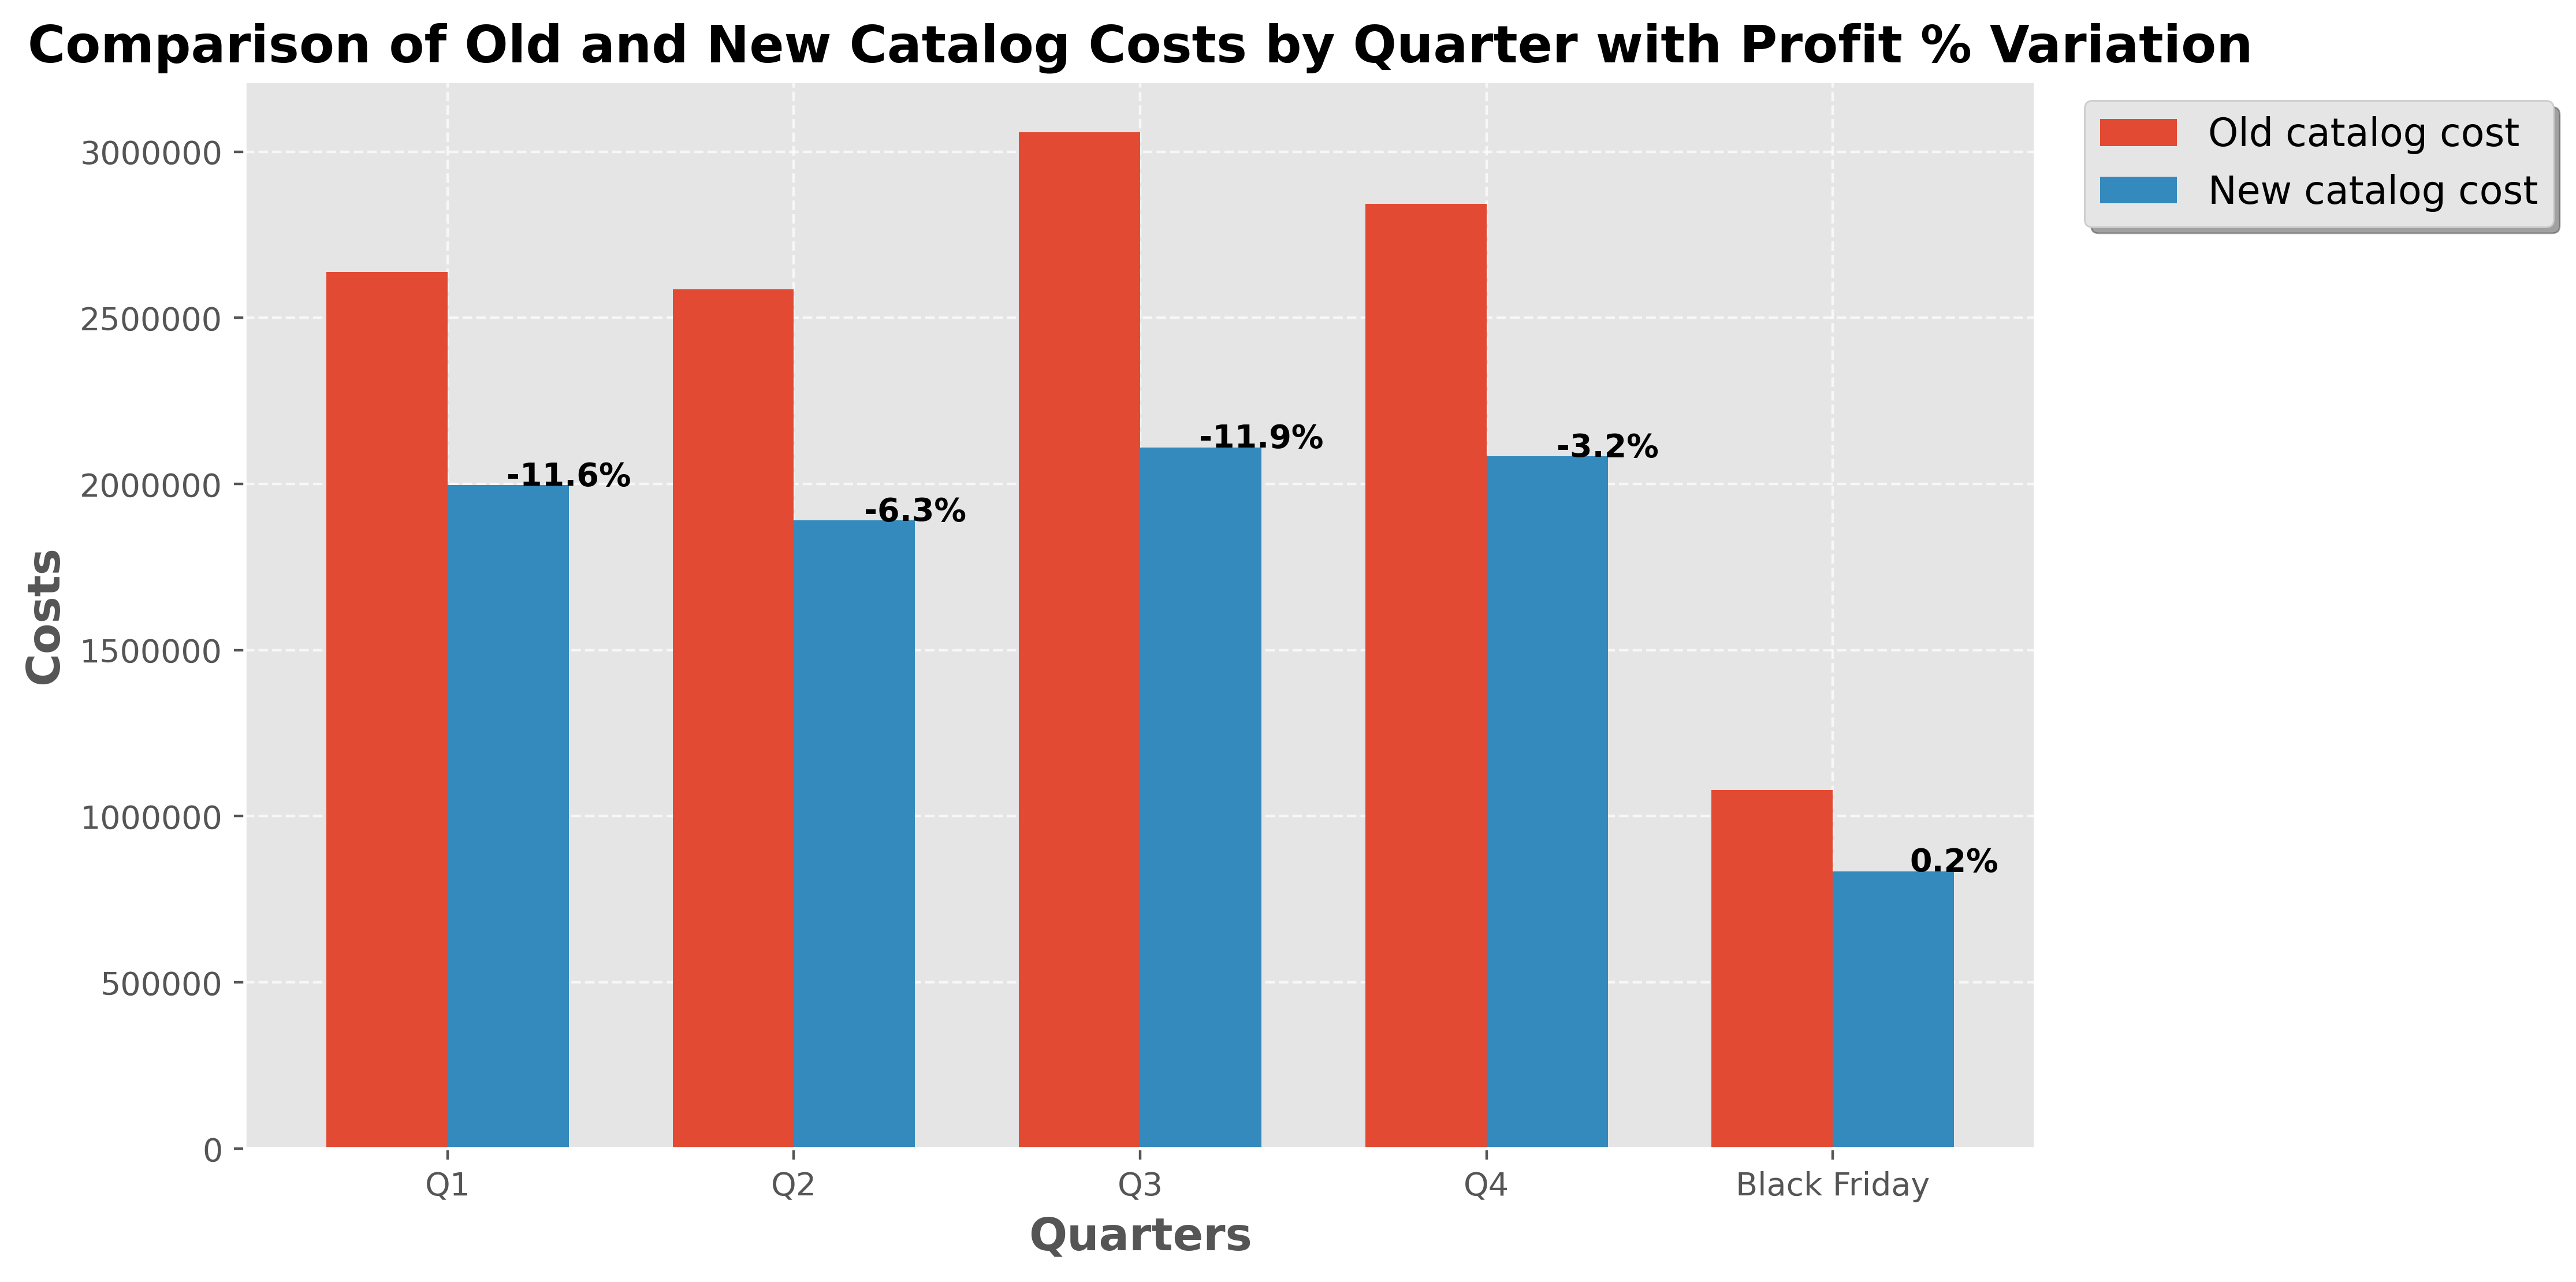

In [ ]:
# Calculating the profit percentage variation
profit_percentage_variation = [
    ((new - old) / old) * 100 if old != 0 else 0
    for old, new in zip(old_catalog_cost_list, new_catalog_with_1681_cost)
]

# Creating the plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=400)

labels = ["Q1","Q2","Q3","Q4","Black Friday"]
width = 0.35
x = np.arange(len(labels))  # positions for the labels

# Bar chart for old and new catalog costs
bars1 = ax.bar(x - width/2, old_catalog_cost_list , width, label='Old catalog cost')
bars2 = ax.bar(x + width/2, New_catalog_costs, width, label='New catalog cost')

for i, v in enumerate(profit_percentage_variation):
    ax.text(x[i] + width, New_catalog_costs[i] + 10, f"{v:.1f}%",
            color='black', fontweight='bold', ha='center')


# Setting titles and labels
ax.set_xlabel('Quarters', fontsize=14, fontweight='bold')
ax.set_ylabel('Costs', fontsize=14, fontweight='bold')
ax.set_title('Comparison of Old and New Catalog Costs by Quarter with Profit % Variation', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Legends and grid settings
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=12, shadow=True)
ax.ticklabel_format(style='plain', axis='y')
ax.grid(True, linestyle='--', alpha=0.7)

plt.show()

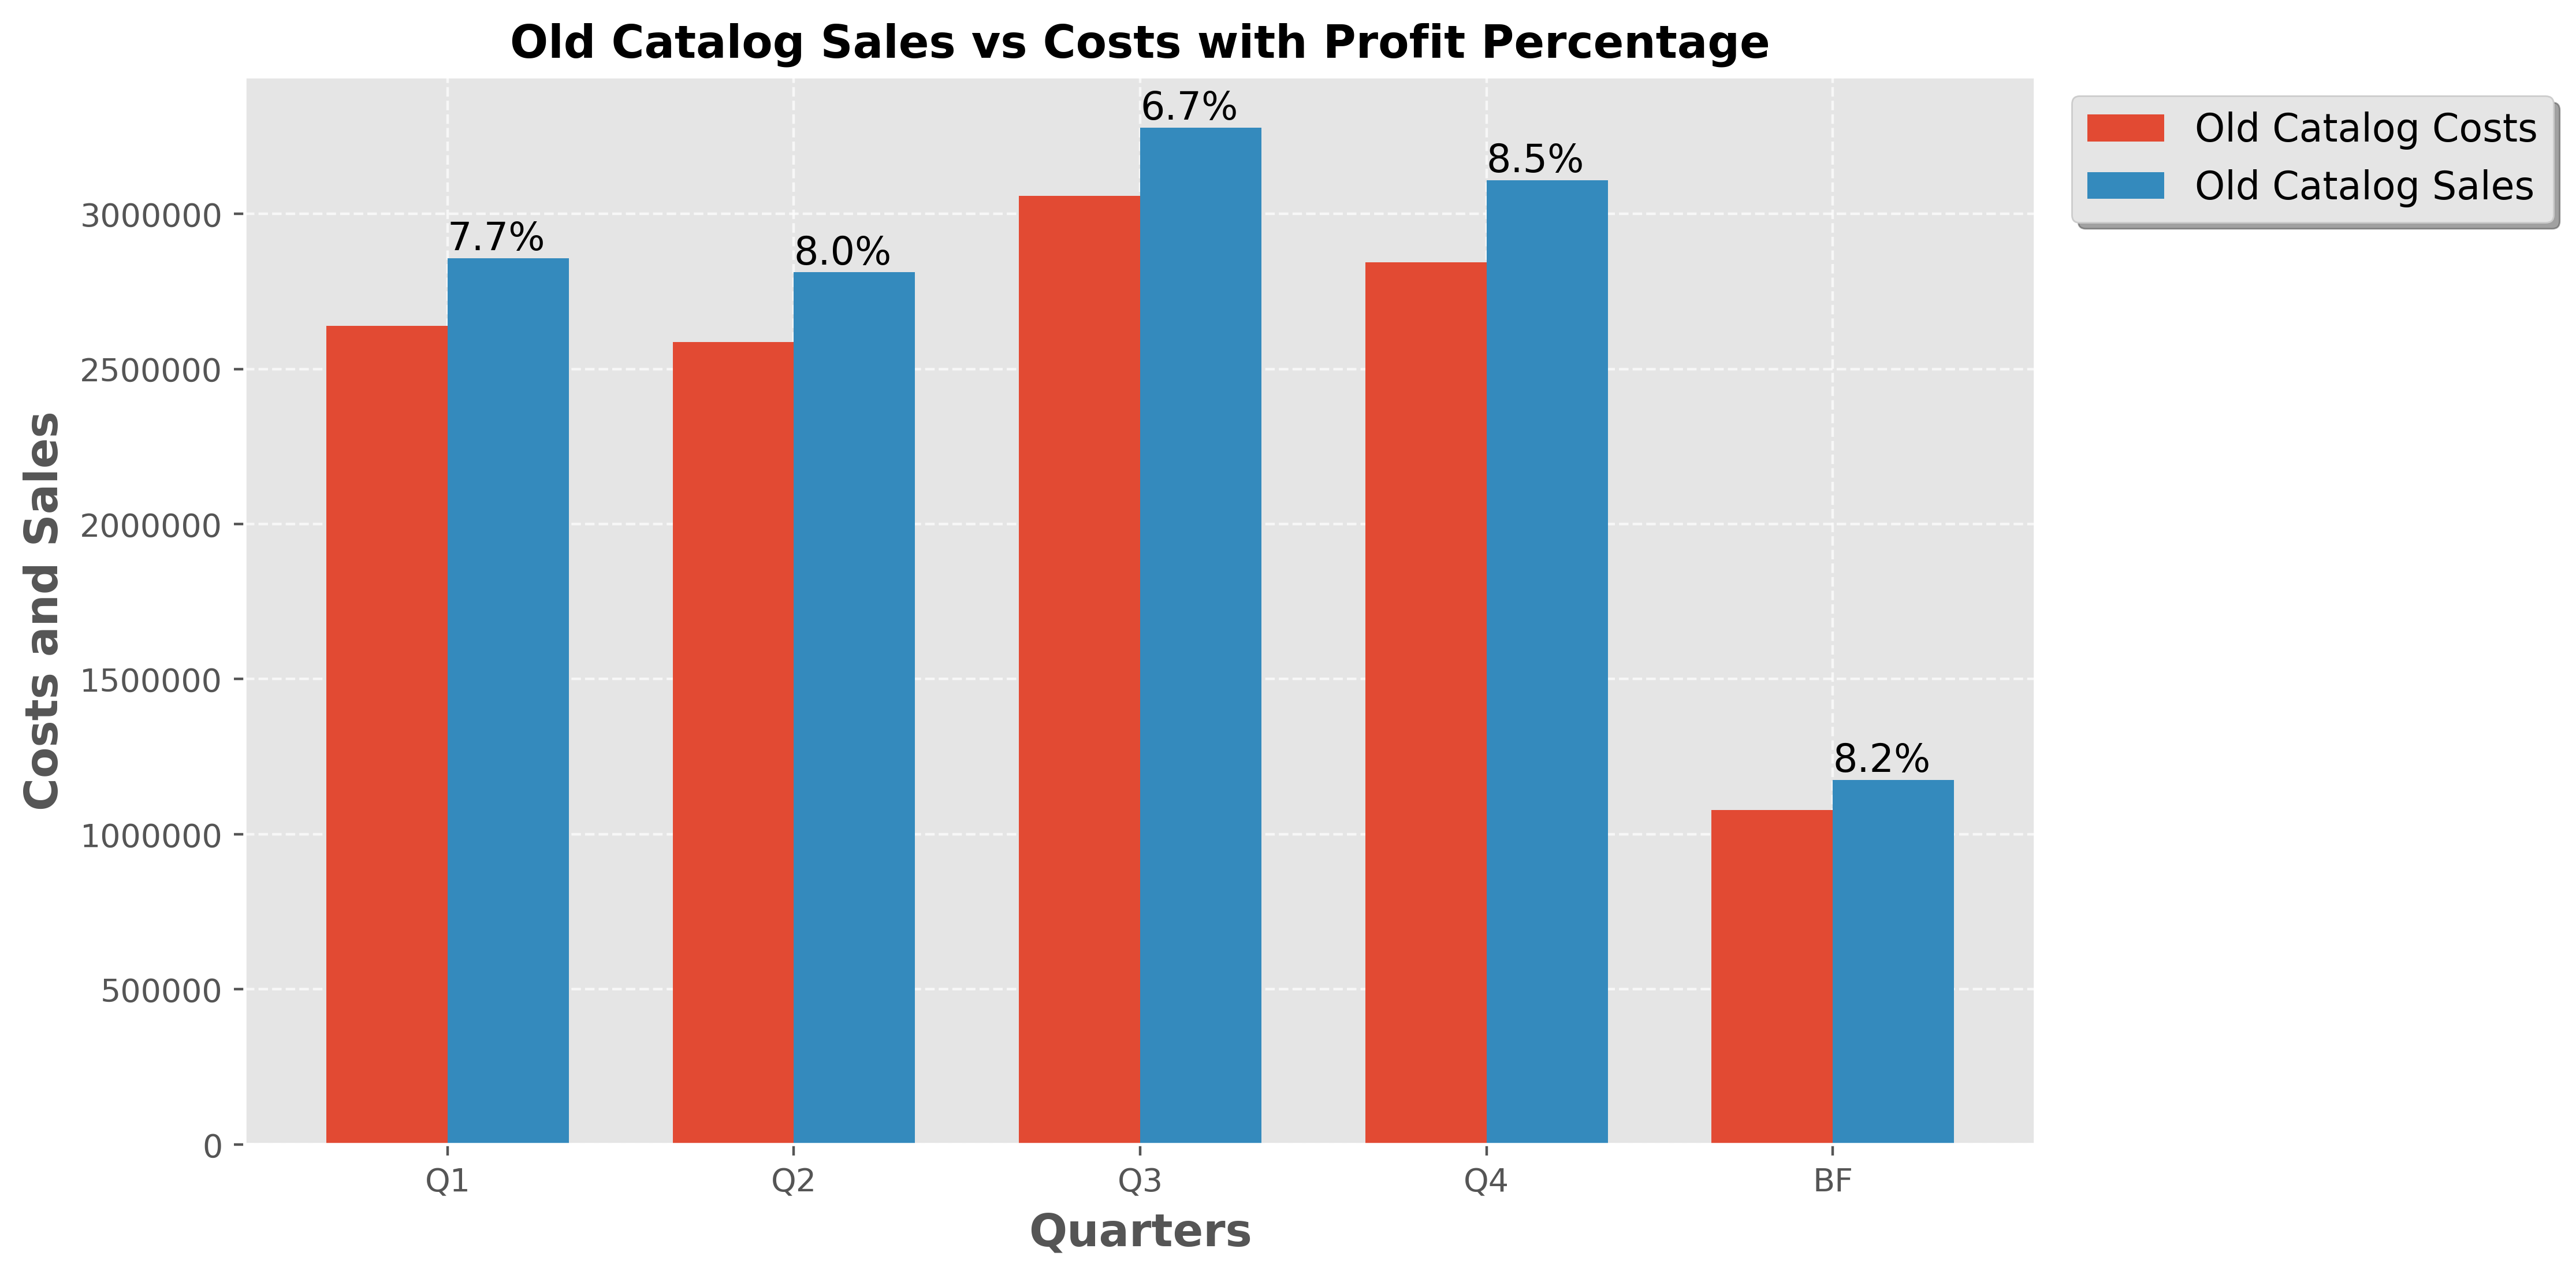

In [ ]:
# Calculation of profit percentage for each quarter
old_profit_percentage = [(old_sales - old_cost) / old_sales * 100 for old_cost, old_sales in zip(old_catalog_cost_list, old_catalog_sales)]

labels = ["Q1", "Q2", "Q3", "Q4",'BF']
width = 0.35  # Width of bars
x = np.arange(len(labels))  # Label positions

# Settings to improve the visual appearance of the graph
plt.style.use('ggplot')

# Creating the stacked bar chart with adjustments
fig, ax = plt.subplots(figsize=(10, 6), dpi=400)


# Creating bars for costs and sales
bars1 = ax.bar(x - width/2, old_catalog_cost_list, width, label='Old Catalog Costs')
bars2 = ax.bar(x + width/2, old_catalog_sales, width, label='Old Catalog Sales')

# Adding profit percentage labels above the bars
for i in range(len(old_profit_percentage)):
    ax.text(x[i], old_catalog_sales[i] + 10, f'{old_profit_percentage[i]:.1f}%', ha='left', va='bottom', fontsize=12)


ax.set_xlabel('Quarters', fontsize=14, fontweight='bold')
ax.set_ylabel('Costs and Sales', fontsize=14, fontweight='bold')
ax.set_title('Old Catalog Sales vs Costs with Profit Percentage', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
# Positioning the legend outside the graph, top right
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=12, shadow=True)

# Y-axis and grid settings
ax.ticklabel_format(style='plain', axis='y')
ax.grid(True, linestyle='--', alpha=0.7)  # Grid with style and transparency

plt.show()

**PROFIT ON NEW CATALOG PLOT**

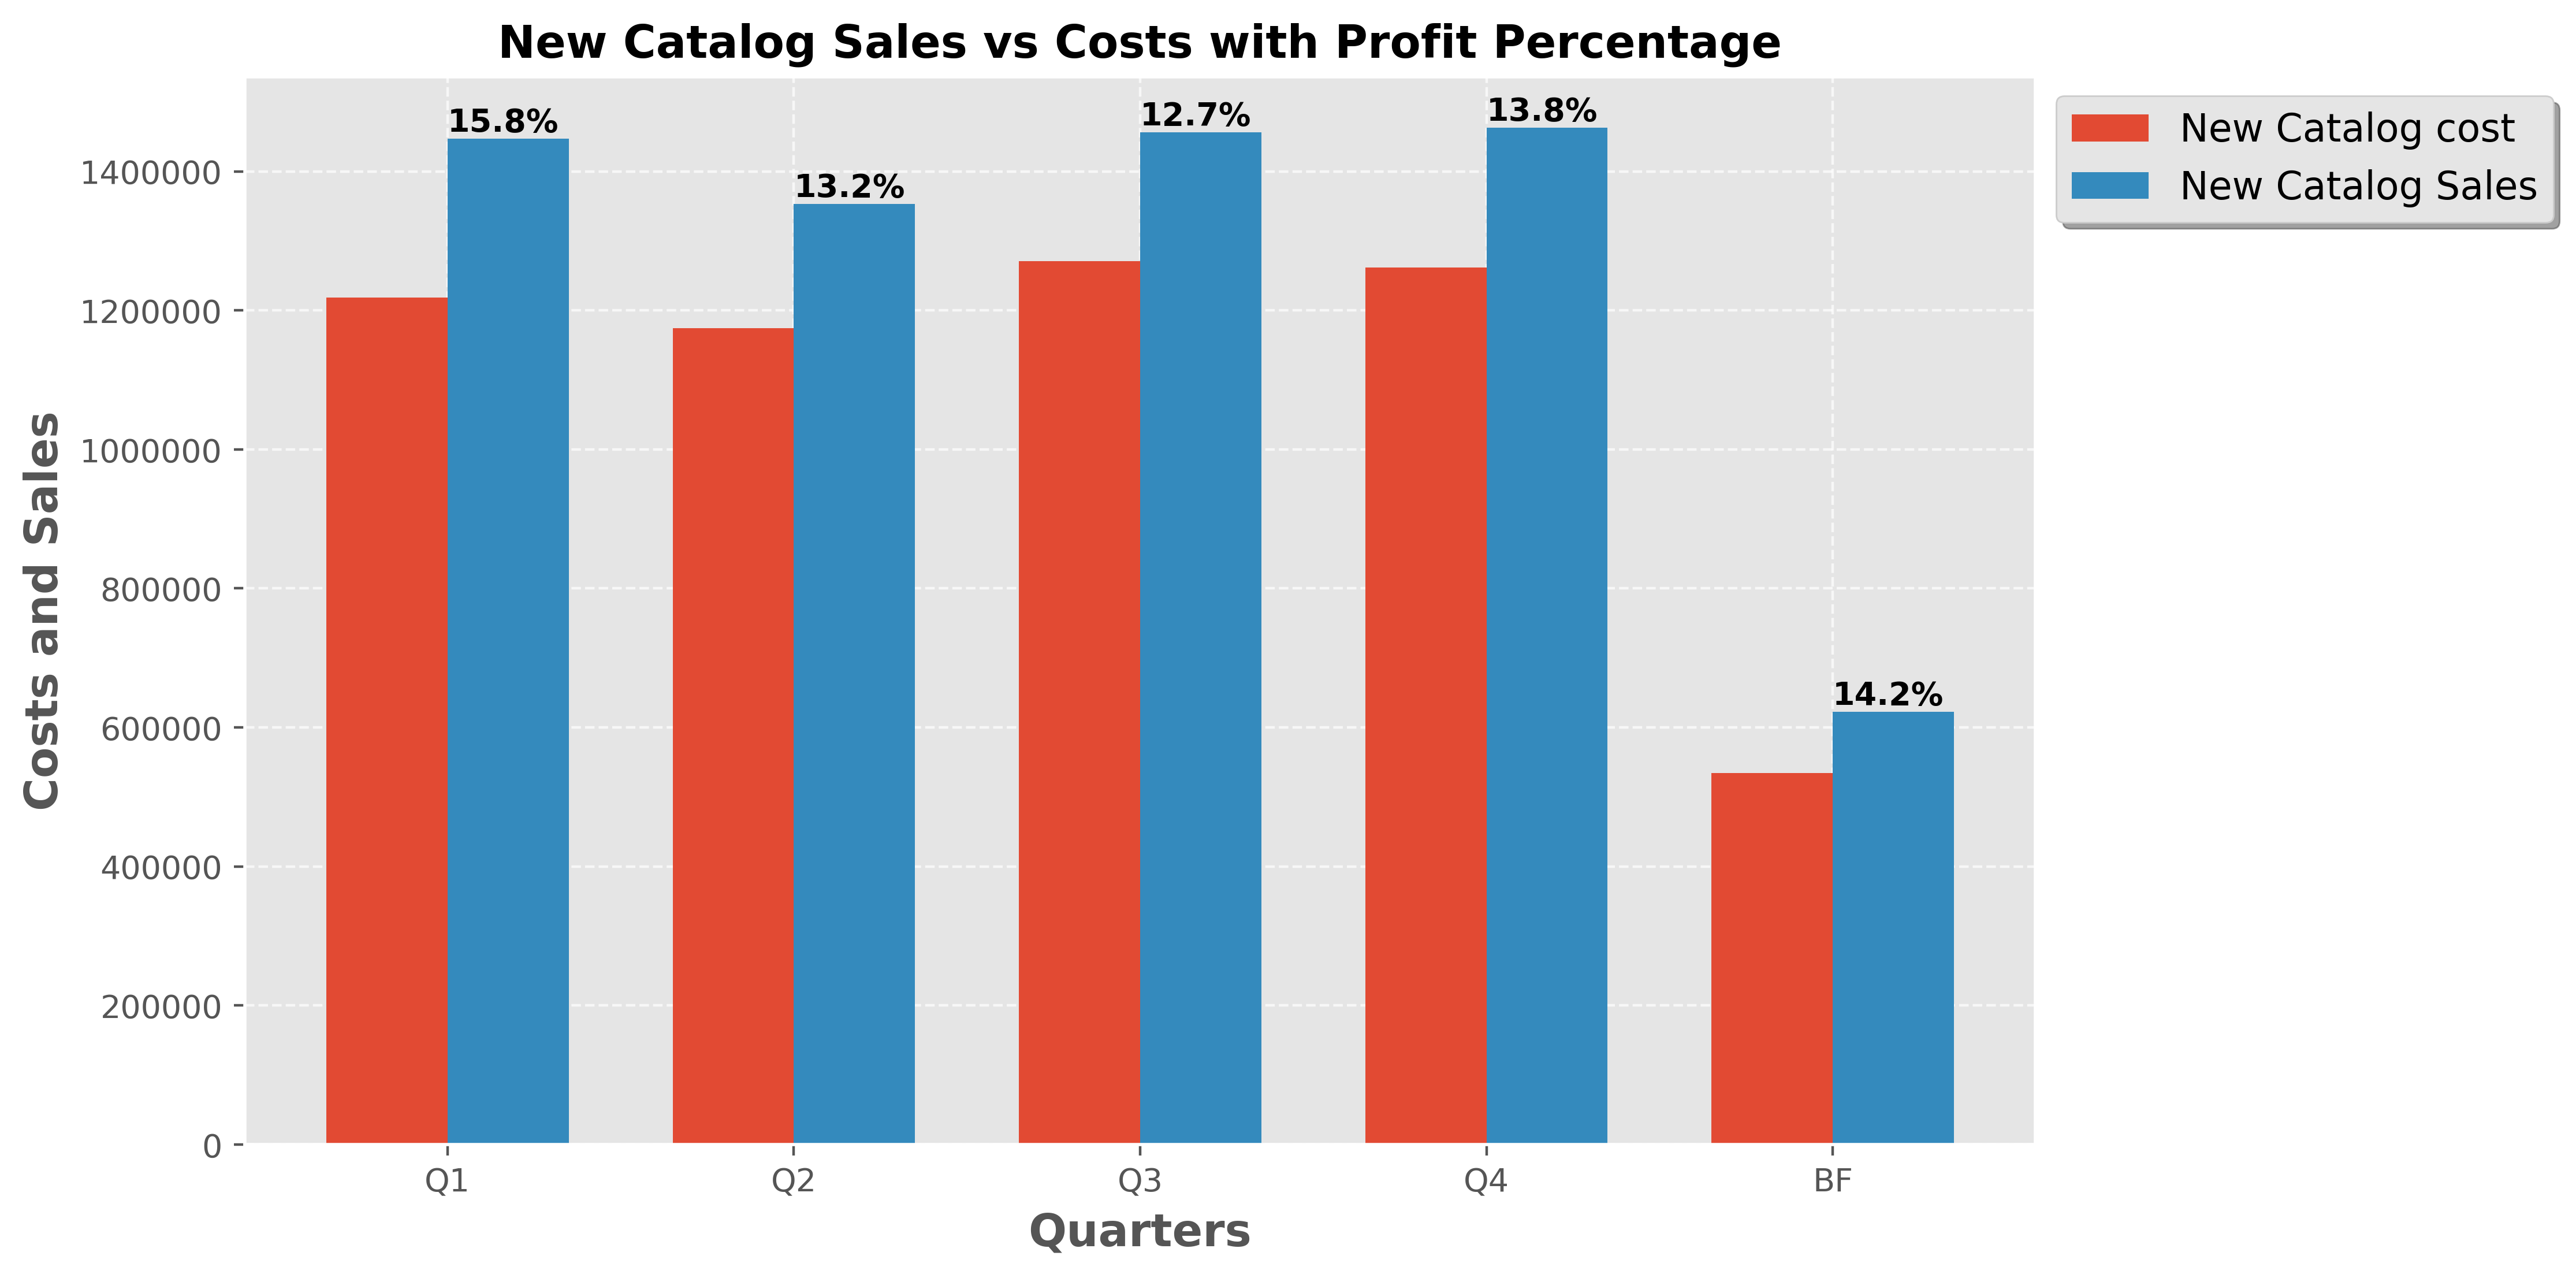

In [ ]:
# Calculation of profit percentage for each quarter
new_profit_percentage = [(sales - cost) / sales * 100 for cost, sales in zip(New_catalog_costs, new_catalog_with_1681_sales)]

labels = ["Q1", "Q2", "Q3", "Q4",'BF']
width = 0.35
x = np.arange(len(labels))

# Settings to improve the visual appearance of the graph
plt.style.use('ggplot')

# Creating the stacked bar chart with adjustments
fig, ax = plt.subplots(figsize=(10, 6), dpi=400)

# Creating bars for costs and sales
bars1 = ax.bar(x - width/2, New_catalog_costs, width, label='New Catalog cost')
bars2 = ax.bar(x + width/2, new_catalog_with_1681_sales, width, label='New Catalog Sales')

for i in range(len(new_profit_percentage)):
    height = max(New_catalog_costs[i], new_catalog_with_1681_sales[i])
    ax.text(x[i], height + 1, f'{new_profit_percentage[i]:.1f}%', ha='left', va='bottom', fontsize=10, fontweight='bold')


ax.set_xlabel('Quarters', fontsize=14, fontweight='bold')
ax.set_ylabel('Costs and Sales', fontsize=14, fontweight='bold')
ax.set_title('New Catalog Sales vs Costs with Profit Percentage', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
# Positioning the legend outside the graph, top right
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=12, shadow=True)

# Y-axis and grid settings
ax.ticklabel_format(style='plain', axis='y')
ax.grid(True, linestyle='--', alpha=0.7)  # Grid with style and transparency

plt.show()

In [ ]:
# Calculating the difference between the elements of the two lists
new_catalog_profit = [sale - cost for sale, cost in zip(new_catalog_with_1681_sales,New_catalog_costs)]

old_catalog_profit = [sale - cost for sale, cost in zip(old_catalog_sales, old_catalog_cost_list)]

In [ ]:
print(new_catalog_profit)
print(old_catalog_profit)

[437847.76722928626, 279341.29925529845, 285765.3626520969, 293878.13552676723, 132179.13300401834]
[218823.13674975745, 225212.1576341344, 219264.16835763352, 265394.56335982075, 95884.70587929431]


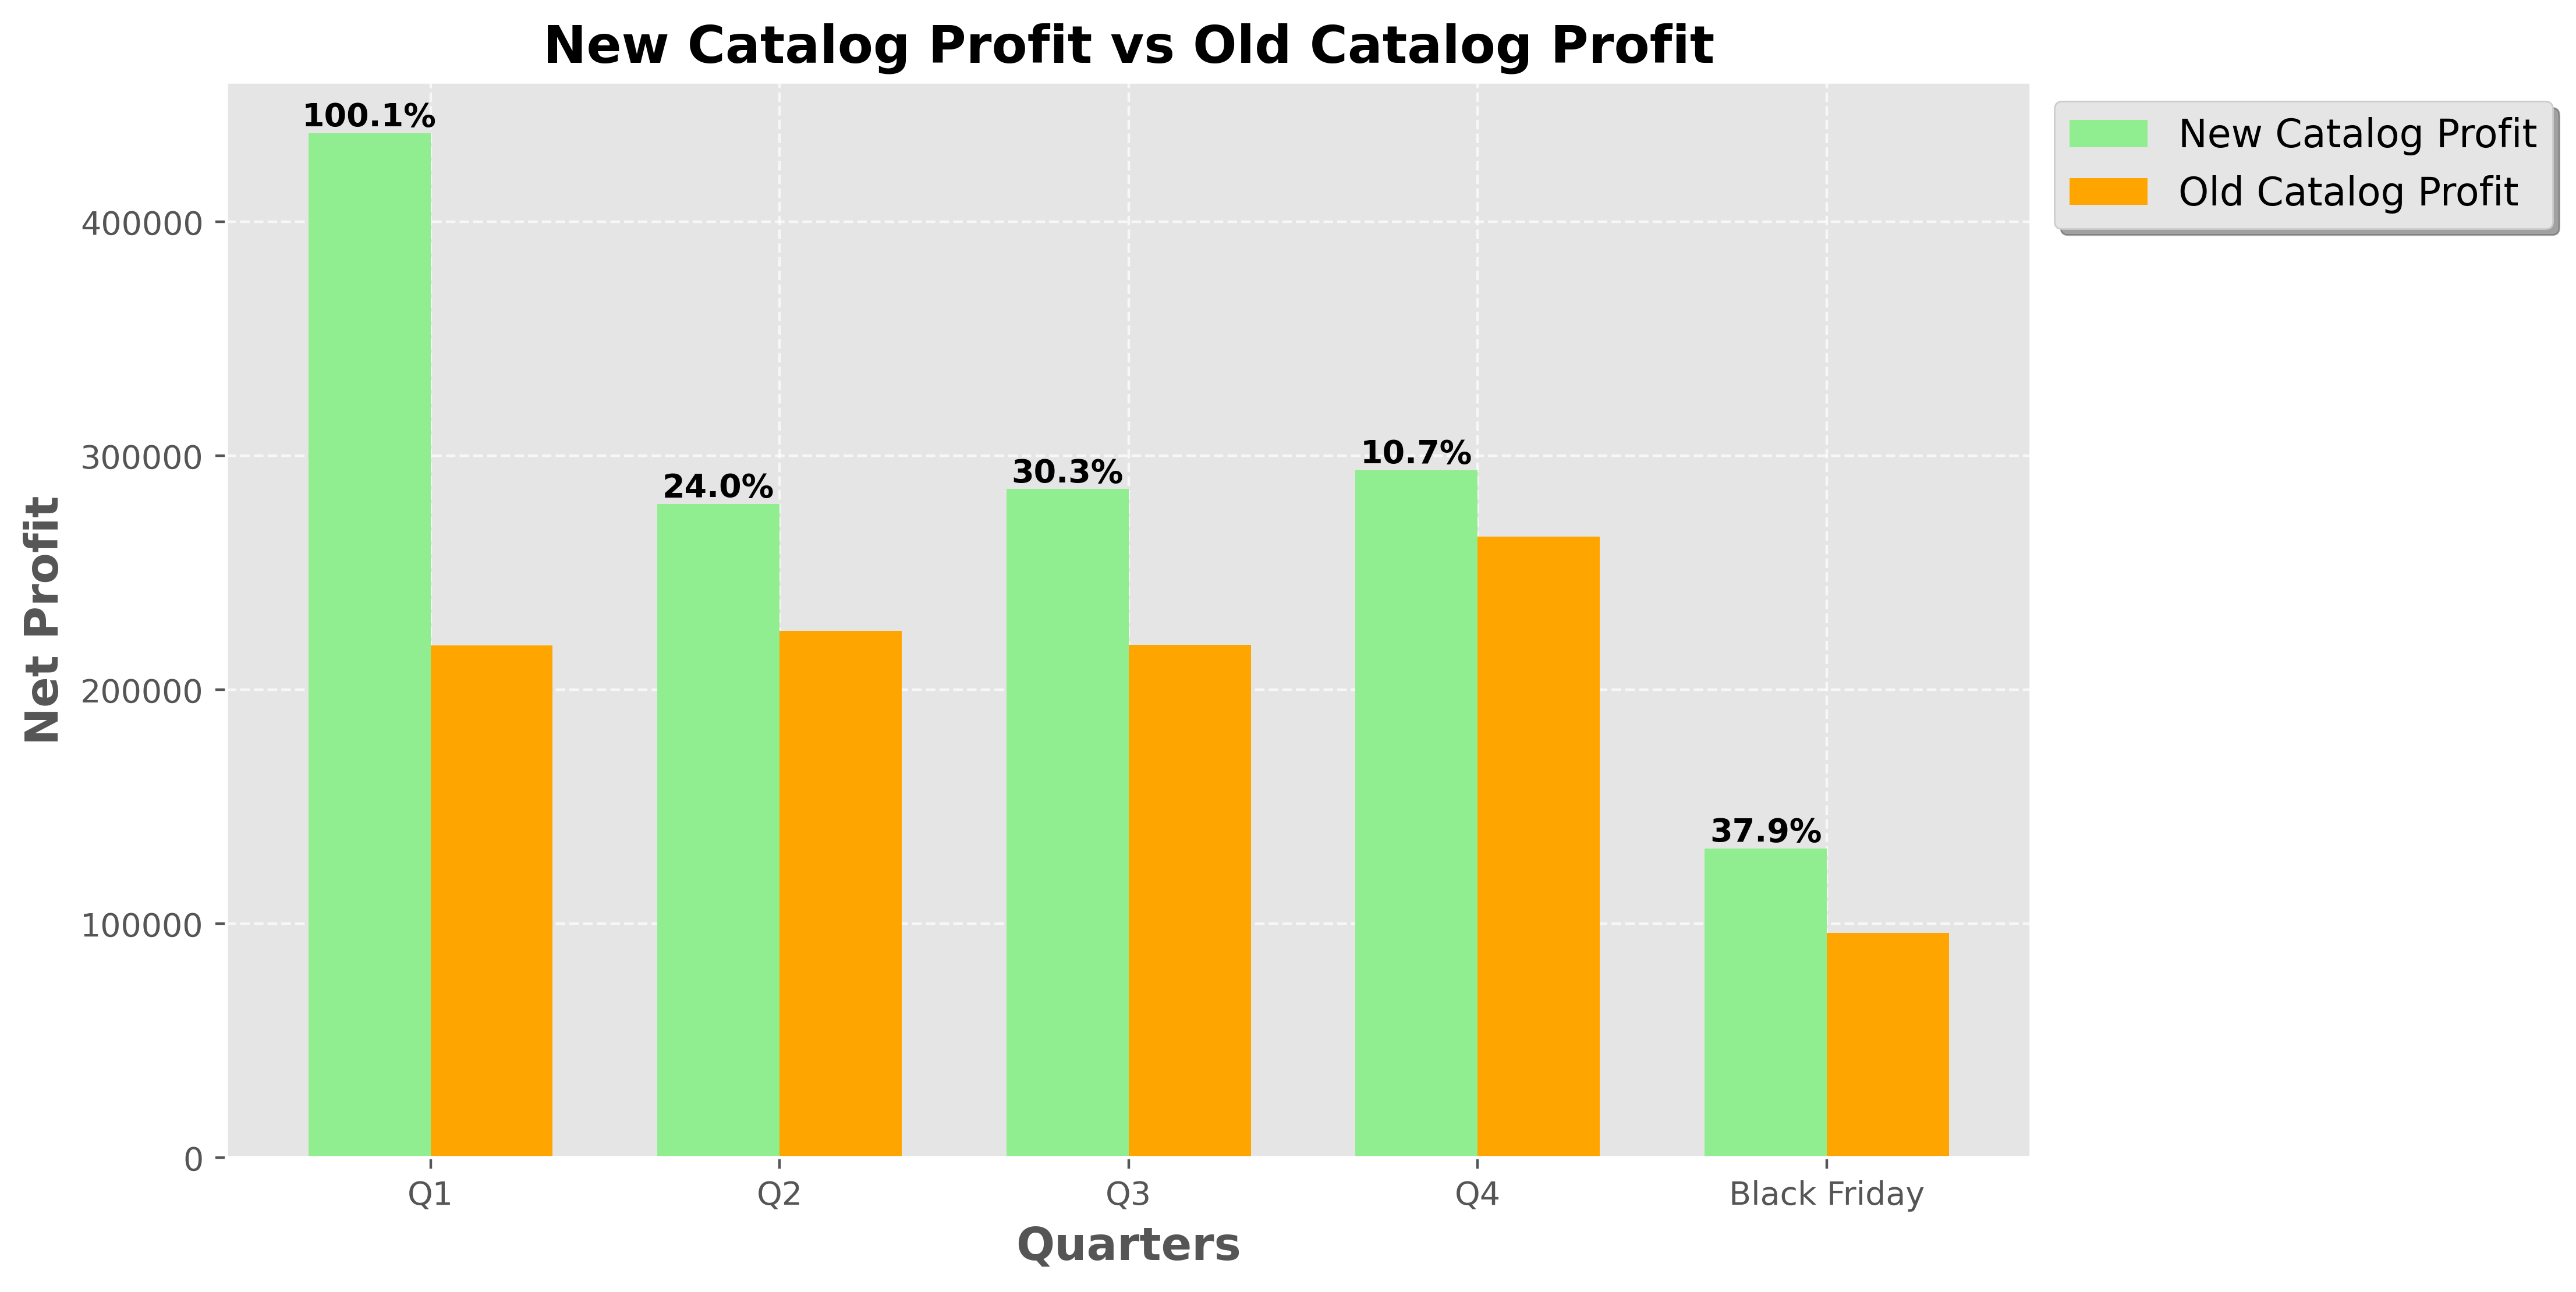

In [ ]:
# Calculation of the percentage increase in profits
percentage_increase = [(new - old) / old * 100 if old != 0 else 0 for new, old in zip(new_catalog_profit, old_catalog_profit)]

labels = ["Q1", "Q2", "Q3", "Q4",'Black Friday']
width = 0.35
x = np.arange(len(labels))

# Creating the stacked bar chart with adjustments
fig, ax = plt.subplots(figsize=(10, 6), dpi=400)

# Creation of profit bars for new and old catalogues
bars1 = ax.bar(x - width/2, new_catalog_profit, width, label='New Catalog Profit', color="lightgreen")
bars2 = ax.bar(x + width/2, old_catalog_profit, width, label='Old Catalog Profit', color="orange")

# Adding percentage increase labels above the bars
for i in range(len(percentage_increase)):
    ax.text(x[i] - width/2, new_catalog_profit[i] + 5, f'{percentage_increase[i]:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Quarters', fontsize=14, fontweight='bold')
ax.set_ylabel('Net Profit', fontsize=14, fontweight='bold')
ax.set_title('New Catalog Profit vs Old Catalog Profit', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
# Positioning the legend outside the graph, top right
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=12, shadow=True)

# Y-axis and grid settings
ax.ticklabel_format(style='plain', axis='y')
ax.grid(True, linestyle='--', alpha=0.7)

plt.show()

In [ ]:
df_task_2_1681 = prices_competitor.filter(prices_competitor["seller_id"] == 1681)

In [ ]:
def most_relevant_product_for_profit_1681(df):
    # We drop date rooms to avoid problems during groupbys, we already have one date column.
    #df = df.drop('sale_date')
    # compute the net profit for each purchase
    df = df.withColumn("net_profit", F.col("sales_price") - F.col("purchase_price"))

    # We calculate the sum net_profit and the sum purchase_price for each product_id
    df = df.groupBy("product_id").agg(
        F.sum("net_profit").alias("total_net_profit_per_product"),
        F.sum("purchase_price").alias("total_cost_per_product"),
        F.sum("sales_price").alias("total_sales_per_product")
    )

    # Ordiniamo in base al total_net_profit_per_product in ordine discendente
    df = df.orderBy(F.desc("total_net_profit_per_product"))

    # We sort by total_net_profit_per_product in descending order.
    total_profit_result = df.agg(F.sum("total_net_profit_per_product").alias("total_profit"))

    # We extract the total value of net profit.
    total_net_profit = total_profit_result.collect()[0]["total_profit"]
    total_cost_result = df.agg(F.sum("total_cost_per_product").alias("total_cost"))
    total_cost = total_cost_result.collect()[0]["total_cost"]

    # We add the column with the percentage of net_profit of each product to the total
    df = df.withColumn("percent_of_total", (F.col("total_net_profit_per_product") / total_net_profit) * 100)

    # We define a sorting window based on the percent_of_total column.
    windowSpec = Window.orderBy(F.desc("percent_of_total")).rangeBetween(Window.unboundedPreceding, 0)

    # Let's add the column with the cumulative percentage.
    df = df.withColumn("cumulative_percentage_of_profit", F.sum("percent_of_total").over(windowSpec))

    return df, total_net_profit

In [ ]:
#prendiamo i sales_data del 576 del 2021
sales_data_576_2021 = sales_data_576.filter((sales_data_576["sale_date"] >= "2021-01-01") & (sales_data_576["sale_date"] <= "2021-12-31"))


In [ ]:
from pyspark.sql import functions as F
# Join sales_data with prices_competitors on product_id and date
sales_data_1681 = sales_data.join(df_task_2_1681, (sales_data["product_id"] == df_task_2_1681["product_id"]) & (sales_data["sale_date"] == df_task_2_1681["comp_date"])).drop(df_task_2_1681["product_id"])
sales_data_1681_2021 = sales_data_1681.filter((sales_data_1681["sale_date"] >= "2021-01-01") & (sales_data_1681["sale_date"] <= "2021-12-31"))
# check if sales_price_tax of sales_data and price of price_competitors match to make sure the join is done right


In [ ]:
# Primo Trimestre (Gennaio - Marzo)
sales_data_1681_Q1 = sales_data_1681.filter((sales_data_1681["sale_date"] >= "2021-01-01") & (sales_data_1681["sale_date"] <= "2021-03-31"))

# Secondo Trimestre (Aprile - Giugno)
sales_data_1681_Q2 = sales_data_1681.filter((sales_data_1681["sale_date"] >= "2021-04-01") & (sales_data_1681["sale_date"] <= "2021-06-30"))

# Terzo Trimestre (Luglio - Settembre)
sales_data_1681_Q3 = sales_data_1681.filter((sales_data_1681["sale_date"] >= "2021-07-01") & (sales_data_1681["sale_date"] <= "2021-09-30"))

# Quarto Trimestre (Ottobre - Dicembre)
sales_data_1681_Q4 = sales_data_1681.filter((sales_data_1681["sale_date"] >= "2021-10-01") & (sales_data_1681["sale_date"] <= "2021-12-31"))

# Quarto Trimestre (Ottobre - Dicembre)
sales_data_1681_BF = sales_data_1681.filter((sales_data_1681["sale_date"] >= "2021-11-01") & (sales_data_1681["sale_date"] <= "2021-11-30"))


In [ ]:
#calcoliamo i più relevant con la percentuale cumulata
most_relevant_for_profit_1681_Q1, total_net_profit_1681_Q1 = most_relevant_product_for_profit_1681(sales_data_1681_Q1)
most_relevant_for_profit_1681_Q2, total_net_profit_1681_Q2 = most_relevant_product_for_profit_1681(sales_data_1681_Q2)
most_relevant_for_profit_1681_Q3, total_net_profit_1681_Q3 = most_relevant_product_for_profit_1681(sales_data_1681_Q3)
most_relevant_for_profit_1681_Q4, total_net_profit_1681_Q4 = most_relevant_product_for_profit_1681(sales_data_1681_Q4)
most_relevant_for_profit_1681_BF, total_net_profit_1681_BF = most_relevant_product_for_profit_1681(sales_data_1681_BF)
#prendiamone solo 500
new_most_relevant_for_profit_1681_Q1 = most_relevant_for_profit_1681_Q1.limit(500)
new_most_relevant_for_profit_1681_Q2 = most_relevant_for_profit_1681_Q2.limit(500)
new_most_relevant_for_profit_1681_Q3 = most_relevant_for_profit_1681_Q3.limit(500)
new_most_relevant_for_profit_1681_Q4 = most_relevant_for_profit_1681_Q4.limit(500)
new_most_relevant_for_profit_1681_BF = most_relevant_for_profit_1681_BF.limit(500)


In [ ]:
total_net_profit_1681_list = [new_most_relevant_for_profit_1681_Q1,
                              new_most_relevant_for_profit_1681_Q2,
                              new_most_relevant_for_profit_1681_Q3,
                              new_most_relevant_for_profit_1681_Q4,
                              new_most_relevant_for_profit_1681_BF]

In [ ]:
def calculate_totals_1681(df_list):
    total_net_profit = []
    total_cost = []
    total_sales = []

    for df in df_list:
        totals = df.agg(
            F.sum("total_net_profit_per_product").alias("total_net_profit"),
            F.sum("total_cost_per_product").alias("total_cost"),
            F.sum("total_sales_per_product").alias("total_sales")
        ).collect()[0]

        total_net_profit.append(totals["total_net_profit"])
        total_cost.append(totals["total_cost"])
        total_sales.append(totals["total_sales"])

    return total_net_profit, total_cost, total_sales

# Utilizza la funzione sulla tua lista di DataFrames
total_net_profit_1681_list, total_cost_1681_list, total_sales_1681_list = calculate_totals_1681(total_net_profit_1681_list)

In [ ]:
# Select distinct 'product_id' values
distinct_product_ids_1681 = new_most_relevant_for_profit_1681_Q1.select("product_id").distinct()
# Collect these values into a list
distinct_product_ids_list_1681 = [row['product_id'] for row in distinct_product_ids_1681.collect()]

In [ ]:
# Select distinct 'product_id' values
distinct_product_ids_560 = new_most_relevant_for_profit_Q1.select("product_id").distinct()
# Collect these values into a list
distinct_product_ids_list_560 = [row['product_id'] for row in distinct_product_ids_560.collect()]

In [ ]:
#Prodotti Unici in distinct_product_ids_list_1681: Questi sono i prodotti presenti in distinct_product_ids_list_1681 ma non in distinct_product_ids_list_560
in_1681_not_in_576 = set(distinct_product_ids_list_1681) - set(distinct_product_ids_list_560)

In [ ]:
# Converti 'in_1681_not_in_576' in una lista di tuple
product_ids_tuples = [(product_id,) for product_id in in_1681_not_in_576]

# Crea un RDD dal tuo elenco di tuple
rdd = spark.sparkContext.parallelize(product_ids_tuples)

# Converti l'RDD in un DataFrame
prodotti_non_in_560 = rdd.toDF(["product_id"])

In [ ]:
# Esegui una inner join tra i DataFrame
joined_df_Q1 = new_most_relevant_for_profit_1681_Q1.join(prodotti_non_in_560, "product_id", "inner")
joined_df_Q2 = new_most_relevant_for_profit_1681_Q2.join(prodotti_non_in_560, "product_id", "inner")
joined_df_Q3 = new_most_relevant_for_profit_1681_Q3.join(prodotti_non_in_560, "product_id", "inner")
joined_df_Q4 = new_most_relevant_for_profit_1681_Q4.join(prodotti_non_in_560, "product_id", "inner")
joined_df_BF = new_most_relevant_for_profit_1681_BF.join(prodotti_non_in_560, "product_id", "inner")

In [ ]:
from pyspark.sql import functions as F

def calculate_totals_for_each_df(df_list):
    all_total_costs = []
    all_total_sales = []
    all_total_net_profits = []

    for df in df_list:
        totals = df.agg(
            F.sum("total_cost_per_product").alias("total_cost"),
            F.sum("total_sales_per_product").alias("total_sales"),
            F.sum("total_net_profit_per_product").alias("total_net_profit")
        ).collect()[0]

        all_total_costs.append(totals["total_cost"])
        all_total_sales.append(totals["total_sales"])
        all_total_net_profits.append(totals["total_net_profit"])

    return all_total_costs, all_total_sales, all_total_net_profits

# Crea una lista di tutti i DataFrame joinati
joined_df_list = [joined_df_Q1, joined_df_Q2, joined_df_Q3, joined_df_Q4, joined_df_BF]

# Utilizza la funzione sulla lista di DataFrame
total_costs_list_1681, total_sales_list_1681, total_net_profits_list_1681 = calculate_totals_for_each_df(joined_df_list)
